## New York Airbnb marketplace analysis report.

Original data source: https://www.kaggle.com/datasets/arianazmoudeh/airbnbopendata

In [1]:
from scipy import stats
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer

# for computing the cross validation performance measures
from sklearn.model_selection import cross_val_score

# to implement k-fold cross validation
from sklearn.model_selection import RepeatedKFold

# to perform model hyperparameter optimisation
from sklearn.model_selection import GridSearchCV

# to calculate the mean absolute error
from sklearn.metrics import mean_absolute_error

# to create Ridge and LASSO models
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

4
# to scale the data for LASSO (make a values with mean = 0 and std=1)
from sklearn.preprocessing import StandardScaler 

In [2]:
df = pd.read_csv("Airbnb_2.csv")

## 1.0 Data cleaning 

In [3]:
df.head()

id host_identity_verified neighbourhood_group cancellation_policy  \
0  1001254            unconfirmed            Brooklyn              strict   
1  1002102               verified           Manhattan            moderate   
2  1002403                    NaN           Manhattan            flexible   
3  1002755            unconfirmed            Brooklyn            moderate   
4  1003689               verified           Manhattan            moderate   

         room_type  construction_year  price_us_dol  service_fee  \
0     Private room             2020.0         966.0        193.0   
1  Entire home/apt             2007.0         142.0         28.0   
2     Private room             2005.0         620.0        124.0   
3  Entire home/apt             2005.0         368.0         74.0   
4  Entire home/apt             2009.0         204.0         41.0   

   minimum_nights  number_of_reviews  review_rate_number  
0            10.0                9.0                 4.0  
1            30.0               45.0                 4.0  
2             3.0                0.0                 5.0  
3            30.0              270.0                 4.0  
4            10.0                9.0                 3.0

#### 1.0.1 Data type interpretation

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102599 entries, 0 to 102598
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      102599 non-null  int64  
 1   host_identity_verified  102310 non-null  object 
 2   neighbourhood_group     102570 non-null  object 
 3   cancellation_policy     102523 non-null  object 
 4   room_type               102599 non-null  object 
 5   construction_year       102385 non-null  float64
 6   price_us_dol            102352 non-null  float64
 7   service_fee             102326 non-null  float64
 8   minimum_nights          102190 non-null  float64
 9   number_of_reviews       102416 non-null  float64
 10  review_rate_number      102273 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 8.6+ MB


#### 1.0.2 Determine the number of missing data for each variable and visualization

The first step in the data cleaning process was to check for missing values of all features, using a heatmap visualisation.

In [5]:
df.isnull().sum()

id                          0
host_identity_verified    289
neighbourhood_group        29
cancellation_policy        76
room_type                   0
construction_year         214
price_us_dol              247
service_fee               273
minimum_nights            409
number_of_reviews         183
review_rate_number        326
dtype: int64

<AxesSubplot:>

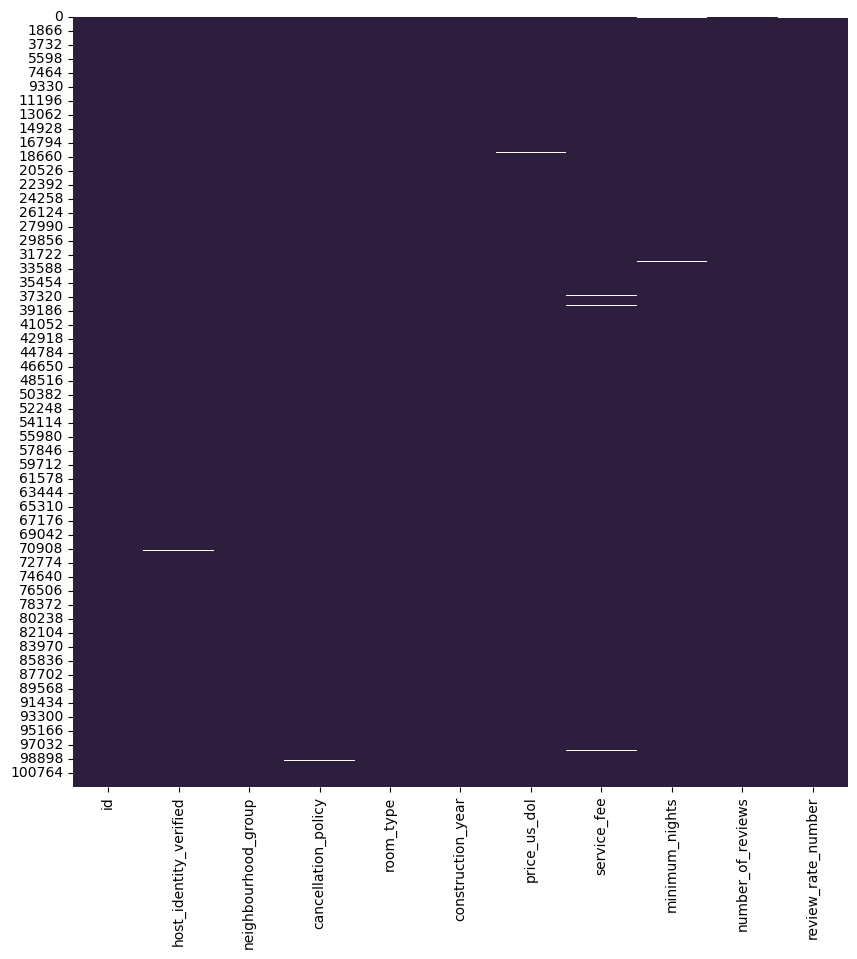

In [6]:
%matplotlib inline
plt.figure(figsize=(10, 10))
colourmap = sns.cubehelix_palette(light=1, as_cmap=True, reverse=True)
sns.heatmap(df.isnull(), cmap=colourmap, cbar=False)

In [7]:
df["room_type"] = df["room_type"].str.lower()

In [8]:
df["room_type"].unique()

array(['private room', 'entire home/apt', 'shared room', 'hotel room'],
      dtype=object)

#### 1.1 host_identity_verified missing values handling

The unique values in the column were ‘unconfirmed’ and ‘verified’. NaN values have been replaced by ‘confirmed’ to keep data features consistent.

In [9]:
df["host_identity_verified"].unique()

array(['unconfirmed', 'verified', nan], dtype=object)

In [10]:
df["host_identity_verified"] = df["host_identity_verified"].replace(np.nan,"confirmed")

-----------------------------------------------------------

#### 1.2 neighbourhood_group variable cleaning

Some variables had misspelling inconsistencies that were cleaned by replacing them with correct ones. Missing values have been replaced by a random variable from the same column using the lambda function and random seed to get keep the same outcome each time model is run.

In [11]:
df["neighbourhood_group"].unique()

array(['Brooklyn', 'Manhattan', 'brookln', 'manhatan', 'Queens', nan,
       'Staten Island', 'Bronx'], dtype=object)

In [12]:
df["neighbourhood_group"] = df["neighbourhood_group"].str.lower()

In [13]:
df[df["neighbourhood_group"].isnull()].head(5)

id host_identity_verified neighbourhood_group cancellation_policy  \
74  1042206              confirmed                 NaN            moderate   
75  1042759            unconfirmed                 NaN              strict   
76  1043311               verified                 NaN              strict   
77  1043863               verified                 NaN              strict   
78  1044415            unconfirmed                 NaN            flexible   

          room_type  construction_year  price_us_dol  service_fee  \
74     private room             2011.0         571.0        114.0   
75     private room             2014.0         398.0         80.0   
76  entire home/apt             2018.0         618.0        124.0   
77     private room             2007.0         116.0         23.0   
78     private room             2012.0          54.0         11.0   

    minimum_nights  number_of_reviews  review_rate_number  
74             2.0               49.0                 2.0  
75             2.0              105.0                 1.0  
76             5.0               21.0                 4.0  
77             1.0              142.0                 4.0  
78            30.0               25.0                 2.0

In [14]:
neighbourhood_group = df["neighbourhood_group"].unique()
neighbourhood_group

array(['brooklyn', 'manhattan', 'brookln', 'manhatan', 'queens', nan,
       'staten island', 'bronx'], dtype=object)

In [15]:
# getting all values with no van's to the new variable
neighbourhood_group_unique = df['neighbourhood_group'].dropna().tolist()

# replacing nan's with random values from the same column using lambda and setting up random seed to always get the same outcome
random.seed(123)
df['neighbourhood_group'] = df['neighbourhood_group'].apply(lambda x: random.choice(neighbourhood_group_unique) if pd.isnull(x) else x)
df['neighbourhood_group']

0          brooklyn
1         manhattan
2         manhattan
3          brooklyn
4         manhattan
            ...    
102594     brooklyn
102595    manhattan
102596     brooklyn
102597       queens
102598    manhattan
Name: neighbourhood_group, Length: 102599, dtype: object

In [16]:
df["neighbourhood_group"].unique()

array(['brooklyn', 'manhattan', 'brookln', 'manhatan', 'queens', 'bronx',
       'staten island'], dtype=object)

In [17]:
df["neighbourhood_group"] = df["neighbourhood_group"].replace("brookln","brooklyn")
df["neighbourhood_group"] = df["neighbourhood_group"].replace("manhatan","manhattan")

In [18]:
# check - no na's
df['neighbourhood_group'].isnull().sum()

0

In [19]:
df['neighbourhood_group'].loc[74:78]

74    manhattan
75     brooklyn
76     brooklyn
77        bronx
78    manhattan
Name: neighbourhood_group, dtype: object

-------------------

#### 1.3 cancellation_policy missing values handling

Missing values have been replaced by a random variable from the same column using the lambda function and random seed to get keep the same outcome each time model is run.

In [20]:
df["cancellation_policy"].unique()

array(['strict', 'moderate', 'flexible', nan], dtype=object)

In [21]:
df[df["cancellation_policy"].isnull()]

id host_identity_verified neighbourhood_group  \
156     1087495               verified           manhattan   
157     1088047            unconfirmed            brooklyn   
158     1088599            unconfirmed           manhattan   
159     1089152            unconfirmed            brooklyn   
160     1089704               verified           manhattan   
...         ...                    ...                 ...   
99096  55732057            unconfirmed           manhattan   
99097  55732609            unconfirmed            brooklyn   
99098  55733161            unconfirmed            brooklyn   
99099  55733714               verified              queens   
99100  55734266            unconfirmed           manhattan   

      cancellation_policy        room_type  construction_year  price_us_dol  \
156                   NaN  entire home/apt             2018.0         738.0   
157                   NaN  entire home/apt             2007.0        1013.0   
158                   NaN  entire home/apt             2004.0         464.0   
159                   NaN  entire home/apt             2006.0         744.0   
160                   NaN  entire home/apt             2014.0         764.0   
...                   ...              ...                ...           ...   
99096                 NaN      shared room             2022.0         502.0   
99097                 NaN     private room             2006.0         958.0   
99098                 NaN     private room             2011.0         234.0   
99099                 NaN  entire home/apt             2020.0         324.0   
99100                 NaN  entire home/apt             2006.0         264.0   

       service_fee  minimum_nights  number_of_reviews  review_rate_number  
156          148.0            45.0              134.0                 3.0  
157          203.0             6.0               27.0                 3.0  
158           93.0             4.0              126.0                 1.0  
159          149.0             3.0               23.0                 2.0  
160          153.0             1.0              234.0                 5.0  
...            ...             ...                ...                 ...  
99096        100.0             1.0               18.0                 3.0  
99097        192.0             1.0                0.0                 4.0  
99098         47.0             2.0                8.0                 4.0  
99099         65.0             2.0                4.0                 2.0  
99100         53.0             4.0                4.0                 5.0  

[76 rows x 11 columns]

In [22]:
# getting all values with no van's to the new variable
cancellation_policy_unique = df['cancellation_policy'].dropna().tolist()

# replacing nan's with random values from the same column using lambda and setting up random seed to always get the same outcome
random.seed(123)
df['cancellation_policy'] = df['cancellation_policy'].apply(lambda x: random.choice(cancellation_policy_unique) if pd.isnull(x) else x)
df['cancellation_policy']

0           strict
1         moderate
2         flexible
3         moderate
4         moderate
            ...   
102594    flexible
102595    moderate
102596    moderate
102597      strict
102598    flexible
Name: cancellation_policy, Length: 102599, dtype: object

In [23]:
df['cancellation_policy'].loc[156:160]

156    flexible
157    moderate
158      strict
159    flexible
160    moderate
Name: cancellation_policy, dtype: object

In [24]:
# checkpoint
df.isnull().sum()

id                          0
host_identity_verified      0
neighbourhood_group         0
cancellation_policy         0
room_type                   0
construction_year         214
price_us_dol              247
service_fee               273
minimum_nights            409
number_of_reviews         183
review_rate_number        326
dtype: int64

------------

#### 1.4 construction_year missing value handling

Missing values have been replaced by a random variable from the same column using the lambda function and random seed to get keep the same outcome each time model is run.

In [25]:
df["construction_year"].unique()

array([2020., 2007., 2005., 2009., 2013., 2015., 2004., 2008., 2010.,
       2019., 2018., 2006., 2016., 2017., 2021., 2003., 2011., 2012.,
       2022., 2014.,   nan])

In [26]:
# getting all values with no van's to the new variable
construction_year_unique = df['construction_year'].dropna().tolist()

# replacing nan's with random values from the same column using lambda and setting up random seed to always get the same outcome
random.seed(123)
df['construction_year'] = df['construction_year'].apply(lambda x: random.choice(construction_year_unique) if pd.isnull(x) else x)
df['construction_year']

0         2020.0
1         2007.0
2         2005.0
3         2005.0
4         2009.0
           ...  
102594    2003.0
102595    2016.0
102596    2009.0
102597    2015.0
102598    2010.0
Name: construction_year, Length: 102599, dtype: float64

In [27]:
# changing type to intigers
df["construction_year"] = df["construction_year"].astype(int)

-------

#### 1.5 minimum_nights - missing values handling

The descriptive statistics of the column show some listings with a minimum stay of 0 nights. We also find some negative values in the column, replaced by 1 night, as the smallest positive value across other observations is 1. The columns also had significant outliers, which were removed by using z-scores for each value in the "minimum_nights" and then setting a threshold of 3 and removing any values greater than this.


In [28]:
df.head()

id host_identity_verified neighbourhood_group cancellation_policy  \
0  1001254            unconfirmed            brooklyn              strict   
1  1002102               verified           manhattan            moderate   
2  1002403              confirmed           manhattan            flexible   
3  1002755            unconfirmed            brooklyn            moderate   
4  1003689               verified           manhattan            moderate   

         room_type  construction_year  price_us_dol  service_fee  \
0     private room               2020         966.0        193.0   
1  entire home/apt               2007         142.0         28.0   
2     private room               2005         620.0        124.0   
3  entire home/apt               2005         368.0         74.0   
4  entire home/apt               2009         204.0         41.0   

   minimum_nights  number_of_reviews  review_rate_number  
0            10.0                9.0                 4.0  
1            30.0               45.0                 4.0  
2             3.0                0.0                 5.0  
3            30.0              270.0                 4.0  
4            10.0                9.0                 3.0

In [29]:
df[df["minimum_nights"].isnull()]

id host_identity_verified neighbourhood_group  \
46       1026742              confirmed            brooklyn   
47       1027294            unconfirmed              queens   
48       1027846               verified            brooklyn   
49       1028399               verified            brooklyn   
50       1028951            unconfirmed            brooklyn   
...          ...                    ...                 ...   
102254  13976520               verified           manhattan   
102255  13977072            unconfirmed              queens   
102256  13977625            unconfirmed           manhattan   
102257  13978177            unconfirmed            brooklyn   
102258  13978729               verified              queens   

       cancellation_policy        room_type  construction_year  price_us_dol  \
46                  strict  entire home/apt               2007         435.0   
47                flexible     private room               2022         916.0   
48                moderate  entire home/apt               2019         459.0   
49                moderate  entire home/apt               2015         363.0   
50                  strict     private room               2009         212.0   
...                    ...              ...                ...           ...   
102254              strict     private room               2021         226.0   
102255            flexible     private room               2017         484.0   
102256            flexible     private room               2021         125.0   
102257            moderate  entire home/apt               2016         538.0   
102258              strict  entire home/apt               2017         291.0   

        service_fee  minimum_nights  number_of_reviews  review_rate_number  
46             87.0             NaN               11.0                 NaN  
47            183.0             NaN              248.0                 NaN  
48             92.0             NaN               61.0                 NaN  
49             73.0             NaN               11.0                 1.0  
50             42.0             NaN              135.0                 1.0  
...             ...             ...                ...                 ...  
102254         45.0             NaN                3.0                 3.0  
102255         97.0             NaN                0.0                 1.0  
102256         25.0             NaN               18.0                 5.0  
102257        108.0             NaN               42.0                 1.0  
102258         58.0             NaN              117.0                 1.0  

[409 rows x 11 columns]

In [30]:
df["minimum_nights"]

0         10.0
1         30.0
2          3.0
3         30.0
4         10.0
          ... 
102594     1.0
102595     1.0
102596     3.0
102597     2.0
102598     1.0
Name: minimum_nights, Length: 102599, dtype: float64

In [31]:
df["minimum_nights"].median()

3.0

In [32]:
df["minimum_nights"].mean()

8.13584499461787

In [33]:
df["minimum_nights"] = df[["minimum_nights"]].replace(np.nan,df[["minimum_nights"]].mean())
df["minimum_nights"] = df["minimum_nights"].round(0)
df["minimum_nights"] = df["minimum_nights"].astype(int)

In [34]:
df["minimum_nights"].isnull().sum()

0

In [35]:
df["minimum_nights"].describe()

count    102599.000000
mean          8.135303
std          30.492821
min       -1223.000000
25%           2.000000
50%           3.000000
75%           5.000000
max        5645.000000
Name: minimum_nights, dtype: float64

In [36]:
df[df["minimum_nights"] == 0]

Empty DataFrame
Columns: [id, host_identity_verified, neighbourhood_group, cancellation_policy, room_type, construction_year, price_us_dol, service_fee, minimum_nights, number_of_reviews, review_rate_number]
Index: []

In [37]:
df[df["minimum_nights"] == 1]

id host_identity_verified neighbourhood_group  \
10      1006859               verified           manhattan   
18      1011277               verified           manhattan   
23      1014039              confirmed            brooklyn   
26      1015696              confirmed            brooklyn   
35      1020667            unconfirmed            brooklyn   
...         ...                    ...                 ...   
102592  6091333            unconfirmed           manhattan   
102593  6091885               verified           manhattan   
102594  6092437               verified            brooklyn   
102595  6092990            unconfirmed           manhattan   
102598  6094647            unconfirmed           manhattan   

       cancellation_policy        room_type  construction_year  price_us_dol  \
10                flexible  entire home/apt               2004         319.0   
18                moderate     private room               2008         460.0   
23                moderate     private room               2017        1050.0   
26                moderate     private room               2021         530.0   
35                  strict     private room               2016         191.0   
...                    ...              ...                ...           ...   
102592            moderate  entire home/apt               2016         787.0   
102593              strict     private room               2017        1099.0   
102594            flexible     private room               2003         844.0   
102595            moderate     private room               2016         837.0   
102598            flexible  entire home/apt               2010        1032.0   

        service_fee  minimum_nights  number_of_reviews  review_rate_number  
10             64.0               1              160.0                 3.0  
18              NaN               1              260.0                 3.0  
23            210.0               1               39.0                 3.0  
26            106.0               1               19.0                 5.0  
35             38.0               1               74.0                 NaN  
...             ...             ...                ...                 ...  
102592        157.0               1                0.0                 2.0  
102593        220.0               1                8.0                 4.0  
102594        169.0               1                0.0                 3.0  
102595        167.0               1                1.0                 2.0  
102598        206.0               1                0.0                 3.0  

[25421 rows x 11 columns]

In [38]:
# minimum nights negative values will be replaced with 1 as the smallest positive value equals 1

df[df["minimum_nights"] < 0]

id host_identity_verified neighbourhood_group  \
176     1098541            unconfirmed            brooklyn   
352     1195746            unconfirmed            brooklyn   
398     1221151               verified            brooklyn   
421     1233854               verified           manhattan   
441     1244900               verified           manhattan   
478     1265335            unconfirmed           manhattan   
525     1291294               verified            brooklyn   
42446  24444262               verified               bronx   
42500  24474086            unconfirmed           manhattan   
42538  24495073               verified            brooklyn   
69749  39523709               verified            brooklyn   
91271  51410309            unconfirmed           manhattan   
91357  51457807               verified            brooklyn   

      cancellation_policy        room_type  construction_year  price_us_dol  \
176              flexible     private room               2008        1155.0   
352              moderate  entire home/apt               2009          73.0   
398              flexible     private room               2015         779.0   
421              flexible  entire home/apt               2008         874.0   
441              moderate  entire home/apt               2021         920.0   
478                strict  entire home/apt               2022         410.0   
525              moderate  entire home/apt               2022         413.0   
42446            moderate     private room               2003        1200.0   
42500            flexible  entire home/apt               2009         711.0   
42538            moderate  entire home/apt               2022          85.0   
69749            moderate     private room               2012         328.0   
91271            moderate  entire home/apt               2007         772.0   
91357            moderate      shared room               2014        1177.0   

       service_fee  minimum_nights  number_of_reviews  review_rate_number  
176          231.0             -10              213.0                 5.0  
352           15.0              -5              104.0                 5.0  
398          156.0              -1               82.0                 2.0  
421          175.0             -10               68.0                 5.0  
441          184.0             -12              203.0                 5.0  
478           82.0              -2              129.0                 2.0  
525           83.0              -3               42.0                 5.0  
42446        240.0           -1223                0.0                 2.0  
42500        142.0            -365               13.0                 4.0  
42538         17.0            -200                3.0                 2.0  
69749         66.0            -125              146.0                 1.0  
91271        154.0             -10                0.0                 3.0  
91357        235.0             -10                9.0                 2.0

In [39]:
df.loc[df["minimum_nights"] < 0, "minimum_nights"] = 1

In [40]:
df["minimum_nights"].value_counts()

1      25434
2      23604
3      16113
30     11653
4       6625
       ...  
74         1
198        1
81         1
43         1
825        1
Name: minimum_nights, Length: 143, dtype: int64

In [41]:
df["minimum_nights"].describe()

count    102599.000000
mean          8.154690
std          30.217074
min           1.000000
25%           2.000000
50%           3.000000
75%           5.000000
max        5645.000000
Name: minimum_nights, dtype: float64

In [42]:
# Calculate z-scores for each column
z_scores = np.abs(stats.zscore(df[['minimum_nights']]))

# Define threshold for outlier removal (e.g. z-score > 3)
threshold = 3

# Remove outliers for each column
df = df[(z_scores < threshold).all(axis=1)]

# Print summary statistics for each column after outlier removal
print(df[[ 'minimum_nights']].describe())

       minimum_nights
count   102182.000000
mean         7.135601
std         10.947287
min          1.000000
25%          2.000000
50%          3.000000
75%          5.000000
max         98.000000


--------

####  1.6 number_of_reviews missing values handling

Missing values have been replaced by column mean. The outcome values have been rounded to 0 decimal places and the data type has been set to the integer.

In [43]:
df["number_of_reviews"].mean()

27.529338522926697

In [44]:
df["number_of_reviews"] = df[["number_of_reviews"]].replace(np.nan,df[["number_of_reviews"]].mean())
df["number_of_reviews"] = df["number_of_reviews"].round(0)
df["number_of_reviews"] = df["number_of_reviews"].astype(int)

In [45]:
# 1.7 review_rate_number - replacung nan's with median as is the same as mean value in the column 

In [46]:
df["review_rate_number"].mean()

3.2801350900272928

In [47]:
df["review_rate_number"].median()

3.0

In [48]:
df["review_rate_number"] = df[["review_rate_number"]].replace(np.nan,df[["review_rate_number"]].median())
df["review_rate_number"] = df["review_rate_number"].astype(int)

In [49]:
df["review_rate_number"].unique()

array([4, 5, 3, 2, 1])

-------------

#### 1.7 price_us_dol (dependent variable) missing value handling

As it is the dependent variable that will be used for predictions, missing values have been replaced using linear interpolation. By using this method, the column standard deviation and mean stays the same.

In [50]:
df[df["price_us_dol"].isnull()]

id host_identity_verified neighbourhood_group  \
147      1082524               verified            brooklyn   
148      1083076               verified           manhattan   
210      1117319              confirmed            brooklyn   
211      1117871              confirmed            brooklyn   
212      1118424              confirmed           manhattan   
...          ...                    ...                 ...   
102046  57361342               verified            brooklyn   
102047  57361894            unconfirmed            brooklyn   
102048  57362446               verified           manhattan   
102049  57362999               verified           manhattan   
102050  57363551            unconfirmed            brooklyn   

       cancellation_policy        room_type  construction_year  price_us_dol  \
147                 strict  entire home/apt               2007           NaN   
148                 strict  entire home/apt               2003           NaN   
210               moderate  entire home/apt               2020           NaN   
211                 strict     private room               2019           NaN   
212               flexible     private room               2016           NaN   
...                    ...              ...                ...           ...   
102046            flexible     private room               2016           NaN   
102047            moderate     private room               2005           NaN   
102048            flexible  entire home/apt               2010           NaN   
102049              strict  entire home/apt               2020           NaN   
102050            moderate  entire home/apt               2016           NaN   

        service_fee  minimum_nights  number_of_reviews  review_rate_number  
147            64.0               4                240                   3  
148           119.0               3                 30                   5  
210           176.0               2                253                   3  
211           152.0               2                 23                   5  
212           151.0               2                115                   2  
...             ...             ...                ...                 ...  
102046          NaN               5                  3                   1  
102047          NaN               7                 15                   4  
102048          NaN               3                 38                   3  
102049          NaN               1                 81                   2  
102050          NaN               2                104                   5  

[244 rows x 11 columns]

In [51]:
df["price_us_dol"].mean()

625.3842237438442

In [52]:
df["price_us_dol"].median()

624.0

In [53]:
df["price_us_dol"].describe()

count    101938.000000
mean        625.384224
std         331.581270
min          50.000000
25%         340.000000
50%         624.000000
75%         913.000000
max        1200.000000
Name: price_us_dol, dtype: float64

In [54]:
df["price_us_dol"] = df["price_us_dol"].interpolate(method="linear")

In [55]:
# rows previously holding null values

df["price_us_dol"].loc[[147,148,210,211,212]]

147    492.333333
148    812.666667
210    227.800000
211    203.600000
212    179.400000
Name: price_us_dol, dtype: float64

In [56]:
df["price_us_dol"].describe()

count    102182.000000
mean        625.213359
std         331.461931
min          50.000000
25%         340.000000
50%         624.000000
75%         913.000000
max        1200.000000
Name: price_us_dol, dtype: float64

In [57]:
df["price_us_dol"].isnull().sum()

0

#### 1.8 service_fee missing values handling

The missing values in the column are also filled using linear interpolation. As this column has similar data kind to the dependent variable, the same methodology has been used.

In [58]:
df["service_fee"].describe()

count    101912.000000
mean        125.046197
std          66.308522
min          10.000000
25%          68.000000
50%         125.000000
75%         183.000000
max         240.000000
Name: service_fee, dtype: float64

In [59]:
df["service_fee"] = df["service_fee"].interpolate(method="linear")

In [60]:
df["service_fee"].describe()

count    102182.000000
mean        125.035197
std          66.273751
min          10.000000
25%          68.000000
50%         125.000000
75%         182.000000
max         240.000000
Name: service_fee, dtype: float64

In [61]:
df["service_fee"].isnull().sum()

0

In [62]:
df.isnull().sum()

id                        0
host_identity_verified    0
neighbourhood_group       0
cancellation_policy       0
room_type                 0
construction_year         0
price_us_dol              0
service_fee               0
minimum_nights            0
number_of_reviews         0
review_rate_number        0
dtype: int64

-------------


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102182 entries, 0 to 102598
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      102182 non-null  int64  
 1   host_identity_verified  102182 non-null  object 
 2   neighbourhood_group     102182 non-null  object 
 3   cancellation_policy     102182 non-null  object 
 4   room_type               102182 non-null  object 
 5   construction_year       102182 non-null  int32  
 6   price_us_dol            102182 non-null  float64
 7   service_fee             102182 non-null  float64
 8   minimum_nights          102182 non-null  int32  
 9   number_of_reviews       102182 non-null  int32  
 10  review_rate_number      102182 non-null  int32  
dtypes: float64(2), int32(4), int64(1), object(4)
memory usage: 11.8+ MB


In [64]:
# Set random seed
np.random.seed(123)

small_df = df.copy()

# Sample 4000 rows randomly
sampled_df = small_df.head(4000)

# Save sampled data as csv
sampled_df.to_csv('sampled_data.csv', index=False)

In [65]:
sampled_df2 = sampled_df.copy()

## 2.0  Data exploratory

In [66]:
df.head()

id host_identity_verified neighbourhood_group cancellation_policy  \
0  1001254            unconfirmed            brooklyn              strict   
1  1002102               verified           manhattan            moderate   
2  1002403              confirmed           manhattan            flexible   
3  1002755            unconfirmed            brooklyn            moderate   
4  1003689               verified           manhattan            moderate   

         room_type  construction_year  price_us_dol  service_fee  \
0     private room               2020         966.0        193.0   
1  entire home/apt               2007         142.0         28.0   
2     private room               2005         620.0        124.0   
3  entire home/apt               2005         368.0         74.0   
4  entire home/apt               2009         204.0         41.0   

   minimum_nights  number_of_reviews  review_rate_number  
0              10                  9                   4  
1              30                 45                   4  
2               3                  0                   5  
3              30                270                   4  
4              10                  9                   3

In [67]:
df.shape

(102182, 11)

#### 2.1 The level of measurement of each variable


|Column||Levels of measurement|
|--------||-----------|
|id|                     |Nominal| 
|host_identity_verified| |Nominal|  
|neighbourhood_group|    |Nominal|  
|cancellation_policy|    |Nominal|  
|room_type|              |Nominal|  
|construction_year|      |Interval|  
|price_us_dol|           |Ratio|  
|service_fee|            |Ratio|  
|minimum_nights|         |Interval|
|number_of_reviews|      |Interval|
|review_rate_number|     |Interval|   

#### 2.2 Descriptive statistics

In [68]:
# id columns can be either numerical or string as 'id' represents qualitative data will be removed.
df.describe()

id  construction_year   price_us_dol    service_fee  \
count  1.021820e+05      102182.000000  102182.000000  102182.000000   
mean   2.915670e+07        2012.487669     625.213359     125.035197   
std    1.625006e+07           5.765838     331.461931      66.273751   
min    1.001254e+06        2003.000000      50.000000      10.000000   
25%    1.510666e+07        2007.000000     340.000000      68.000000   
50%    2.914295e+07        2012.000000     624.000000     125.000000   
75%    4.321128e+07        2017.000000     913.000000     182.000000   
max    5.736742e+07        2022.000000    1200.000000     240.000000   

       minimum_nights  number_of_reviews  review_rate_number  
count   102182.000000      102182.000000       102182.000000  
mean         7.135601          27.530181            3.279247  
std         10.947287          49.486892            1.282554  
min          1.000000           0.000000            1.000000  
25%          2.000000           1.000000            2.000000  
50%          3.000000           7.000000            3.000000  
75%          5.000000          30.000000            4.000000  
max         98.000000        1024.000000            5.000000

#### 2.3  Calculation of the mode and cardinality for all categorical variables.

|Column||Cardinality of categorical data| |Cardinality value|
|--------||-----------|                   |-----------|                  
|id|                     |High|           |101643|
|host_identity_verified| |Low|            |3|
|neighbourhood_group|    |High|           |5|
|cancellation_policy|    |Low|            |3|
|room_type|              |Low|            |4|
|construction_year|      |High|           |20|
|review_rate_number|     |Low|            |5|

--------------

In [69]:
# Calculate cardinality for a column
cardinality = df[['id','host_identity_verified', 'neighbourhood_group' ,
                 'cancellation_policy' , 'room_type','construction_year','review_rate_number' ]].nunique()

print('Cardinality of host_identity_verified:', cardinality)

Cardinality of host_identity_verified: id                        101643
host_identity_verified         3
neighbourhood_group            5
cancellation_policy            3
room_type                      4
construction_year             20
review_rate_number             5
dtype: int64


In [70]:
card_df = df.loc[:,["id","host_identity_verified","neighbourhood_group","cancellation_policy","room_type","construction_year","review_rate_number"]]
card_df

id host_identity_verified neighbourhood_group  \
0       1001254            unconfirmed            brooklyn   
1       1002102               verified           manhattan   
2       1002403              confirmed           manhattan   
3       1002755            unconfirmed            brooklyn   
4       1003689               verified           manhattan   
...         ...                    ...                 ...   
102594  6092437               verified            brooklyn   
102595  6092990            unconfirmed           manhattan   
102596  6093542            unconfirmed            brooklyn   
102597  6094094            unconfirmed              queens   
102598  6094647            unconfirmed           manhattan   

       cancellation_policy        room_type  construction_year  \
0                   strict     private room               2020   
1                 moderate  entire home/apt               2007   
2                 flexible     private room               2005   
3                 moderate  entire home/apt               2005   
4                 moderate  entire home/apt               2009   
...                    ...              ...                ...   
102594            flexible     private room               2003   
102595            moderate     private room               2016   
102596            moderate     private room               2009   
102597              strict  entire home/apt               2015   
102598            flexible  entire home/apt               2010   

        review_rate_number  
0                        4  
1                        4  
2                        5  
3                        4  
4                        3  
...                    ...  
102594                   3  
102595                   2  
102596                   5  
102597                   3  
102598                   3  

[102182 rows x 7 columns]

---------

|Column||Mode||Mode count|
|--------||-----------||-----------|                 
|id|                     |102058 values below|  |2|         
|host_identity_verified| |unconfirmed|   |51200|         
|neighbourhood_group|    |manhattan|  |43806|         
|cancellation_policy|    |moderate|   |34377|         
|room_type|              |entire home/apt|   |53701|         
|construction_year|      |2014|  |5256|         
|review_rate_number|     |3|   |23591|    

In [71]:
# mode values

card_df.mode()

id host_identity_verified neighbourhood_group cancellation_policy  \
0     6026161            unconfirmed           manhattan            moderate   
1     6026714                    NaN                 NaN                 NaN   
2     6027266                    NaN                 NaN                 NaN   
3     6027818                    NaN                 NaN                 NaN   
4     6028371                    NaN                 NaN                 NaN   
..        ...                    ...                 ...                 ...   
534  35605693                    NaN                 NaN                 NaN   
535  35606245                    NaN                 NaN                 NaN   
536  35606797                    NaN                 NaN                 NaN   
537  35607349                    NaN                 NaN                 NaN   
538  35607902                    NaN                 NaN                 NaN   

           room_type  construction_year  review_rate_number  
0    entire home/apt             2014.0                 3.0  
1                NaN                NaN                 NaN  
2                NaN                NaN                 NaN  
3                NaN                NaN                 NaN  
4                NaN                NaN                 NaN  
..               ...                ...                 ...  
534              NaN                NaN                 NaN  
535              NaN                NaN                 NaN  
536              NaN                NaN                 NaN  
537              NaN                NaN                 NaN  
538              NaN                NaN                 NaN  

[539 rows x 7 columns]

In [72]:
df.id.value_counts()

6069241     2
35511249    2
35507383    2
35507935    2
35508488    2
           ..
19818197    1
19817645    1
19817092    1
19816540    1
57367417    1
Name: id, Length: 101643, dtype: int64

In [73]:
df.neighbourhood_group.value_counts()

manhattan        43554
brooklyn         41726
queens           13245
bronx             2707
staten island      950
Name: neighbourhood_group, dtype: int64

In [74]:
df.host_identity_verified.value_counts()

unconfirmed    50992
verified       50908
confirmed        282
Name: host_identity_verified, dtype: int64

In [75]:
df.cancellation_policy.value_counts()

moderate    34246
strict      33975
flexible    33961
Name: cancellation_policy, dtype: int64

In [76]:
df.room_type.value_counts()

entire home/apt    53430
private room       46423
shared room         2213
hotel room           116
Name: room_type, dtype: int64

In [77]:
df.construction_year.value_counts()

2014    5241
2008    5213
2006    5209
2019    5190
2009    5163
2010    5147
2020    5144
2022    5128
2003    5120
2005    5119
2012    5119
2007    5098
2015    5079
2017    5055
2011    5050
2021    5037
2018    5037
2004    5022
2016    5009
2013    5002
Name: construction_year, dtype: int64

In [78]:
df.review_rate_number.value_counts()

3    23491
5    23301
4    23237
2    23001
1     9152
Name: review_rate_number, dtype: int64

#### 2.4 Categorical variables distribution.

A practice to plot the variables was creating a new data frame for a categorical variable, then running each column in a for loop and plotting the results in the charts below.

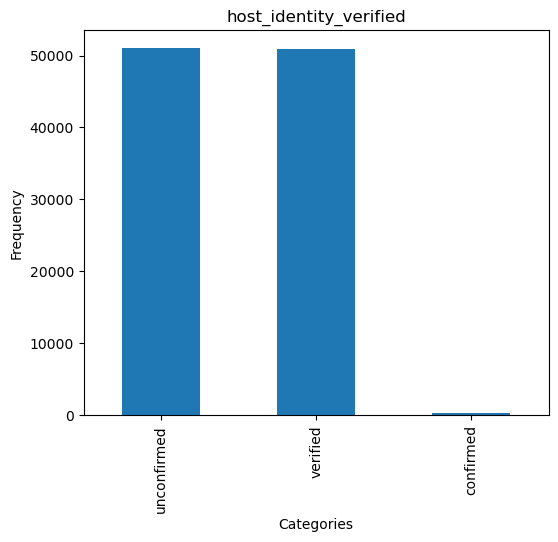

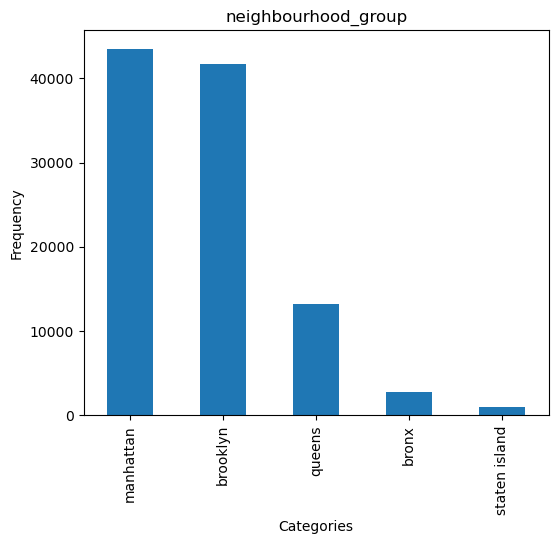

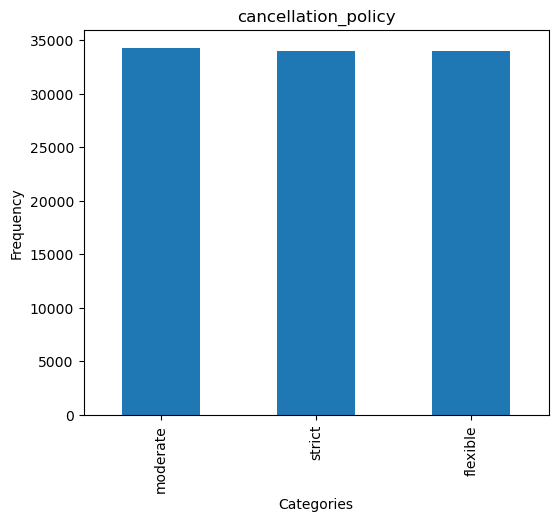

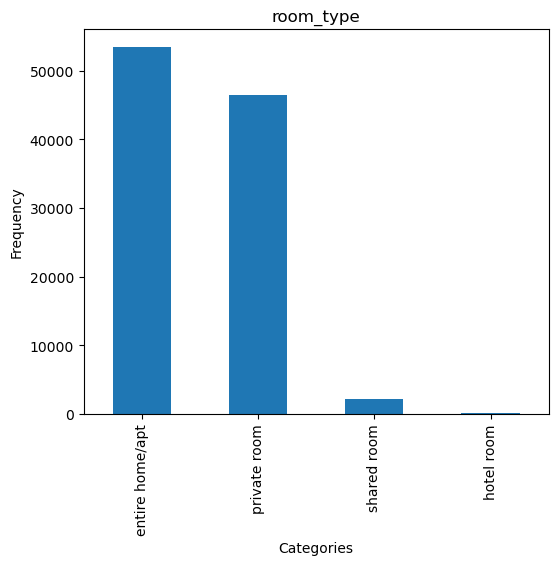

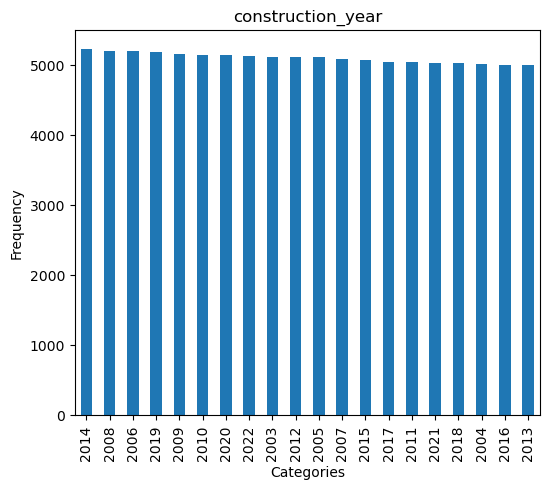

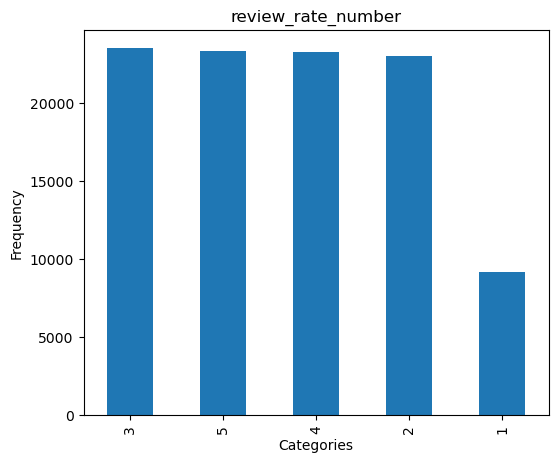

In [79]:
categorical_columns = ['host_identity_verified', 'neighbourhood_group' ,
                 'cancellation_policy' , 'room_type','construction_year','review_rate_number']
for col in categorical_columns:
    plt.figure(figsize=(6,5))
    df[col].value_counts().sort_values(ascending=False).plot(kind='bar')
    plt.title(col)
    plt.xlabel('Categories')
    plt.ylabel('Frequency')
    plt.show()


----


#### 2.5 Scatter plots for all pairs of continuous variables.

In [80]:
df.head(1)

id host_identity_verified neighbourhood_group cancellation_policy  \
0  1001254            unconfirmed            brooklyn              strict   

      room_type  construction_year  price_us_dol  service_fee  minimum_nights  \
0  private room               2020         966.0        193.0              10   

   number_of_reviews  review_rate_number  
0                  9                   4

In [81]:
df_continues_var = df.iloc[:,[5,6,7,8,9,10]]
df_continues_var

construction_year  price_us_dol  service_fee  minimum_nights  \
0                    2020         966.0        193.0              10   
1                    2007         142.0         28.0              30   
2                    2005         620.0        124.0               3   
3                    2005         368.0         74.0              30   
4                    2009         204.0         41.0              10   
...                   ...           ...          ...             ...   
102594               2003         844.0        169.0               1   
102595               2016         837.0        167.0               1   
102596               2009         988.0        198.0               3   
102597               2015         546.0        109.0               2   
102598               2010        1032.0        206.0               1   

        number_of_reviews  review_rate_number  
0                       9                   4  
1                      45                   4  
2                       0                   5  
3                     270                   4  
4                       9                   3  
...                   ...                 ...  
102594                  0                   3  
102595                  1                   2  
102596                  0                   5  
102597                  5                   3  
102598                  0                   3  

[102182 rows x 6 columns]

##### 2.5.1 number of reviews / review rate

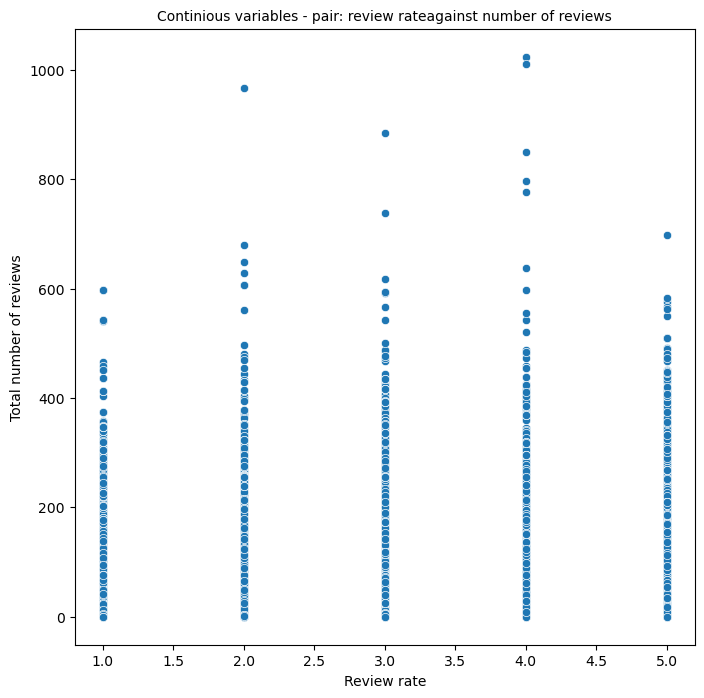

In [82]:
# number of reviews / review rate

plt.figure(figsize=(8,8));
sns.scatterplot(data=df_continues_var, x="review_rate_number", y="number_of_reviews")

plt.title("Continious variables - pair: review rateagainst number of reviews", fontdict={'fontsize':10});
plt.xlabel("Review rate", fontdict={'fontsize' : 10});
plt.ylabel("Total number of reviews", fontdict={'fontsize' : 10});

In [83]:
df_continues_var

construction_year  price_us_dol  service_fee  minimum_nights  \
0                    2020         966.0        193.0              10   
1                    2007         142.0         28.0              30   
2                    2005         620.0        124.0               3   
3                    2005         368.0         74.0              30   
4                    2009         204.0         41.0              10   
...                   ...           ...          ...             ...   
102594               2003         844.0        169.0               1   
102595               2016         837.0        167.0               1   
102596               2009         988.0        198.0               3   
102597               2015         546.0        109.0               2   
102598               2010        1032.0        206.0               1   

        number_of_reviews  review_rate_number  
0                       9                   4  
1                      45                   4  
2                       0                   5  
3                     270                   4  
4                       9                   3  
...                   ...                 ...  
102594                  0                   3  
102595                  1                   2  
102596                  0                   5  
102597                  5                   3  
102598                  0                   3  

[102182 rows x 6 columns]

##### 2.5.2 Number of minimum nights / construction year

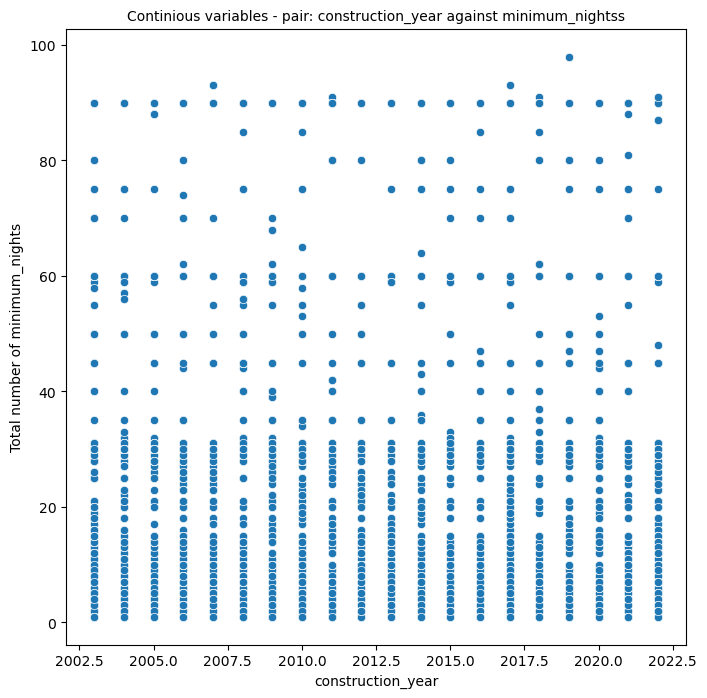

In [84]:
plt.figure(figsize=(8,8));
sns.scatterplot(data=df_continues_var, x="construction_year", y="minimum_nights")

plt.title("Continious variables - pair: construction_year against minimum_nightss", fontdict={'fontsize':10});
plt.xlabel("construction_year", fontdict={'fontsize' : 10});
plt.ylabel("Total number of minimum_nights", fontdict={'fontsize' : 10});

#### 2.5.3 price_us_dol vs service_fee

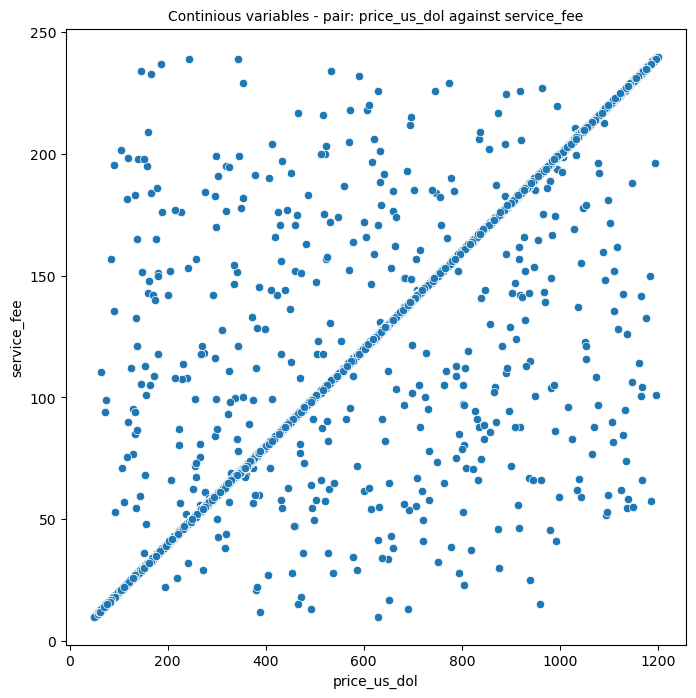

In [85]:
# price_us_dol / service_fee

plt.figure(figsize=(8,8));
sns.scatterplot(data=df_continues_var, x="price_us_dol", y="service_fee")

plt.title("Continious variables - pair: price_us_dol against service_fee", fontdict={'fontsize':10});
plt.xlabel("price_us_dol", fontdict={'fontsize' : 10});
plt.ylabel("service_fee", fontdict={'fontsize' : 10});

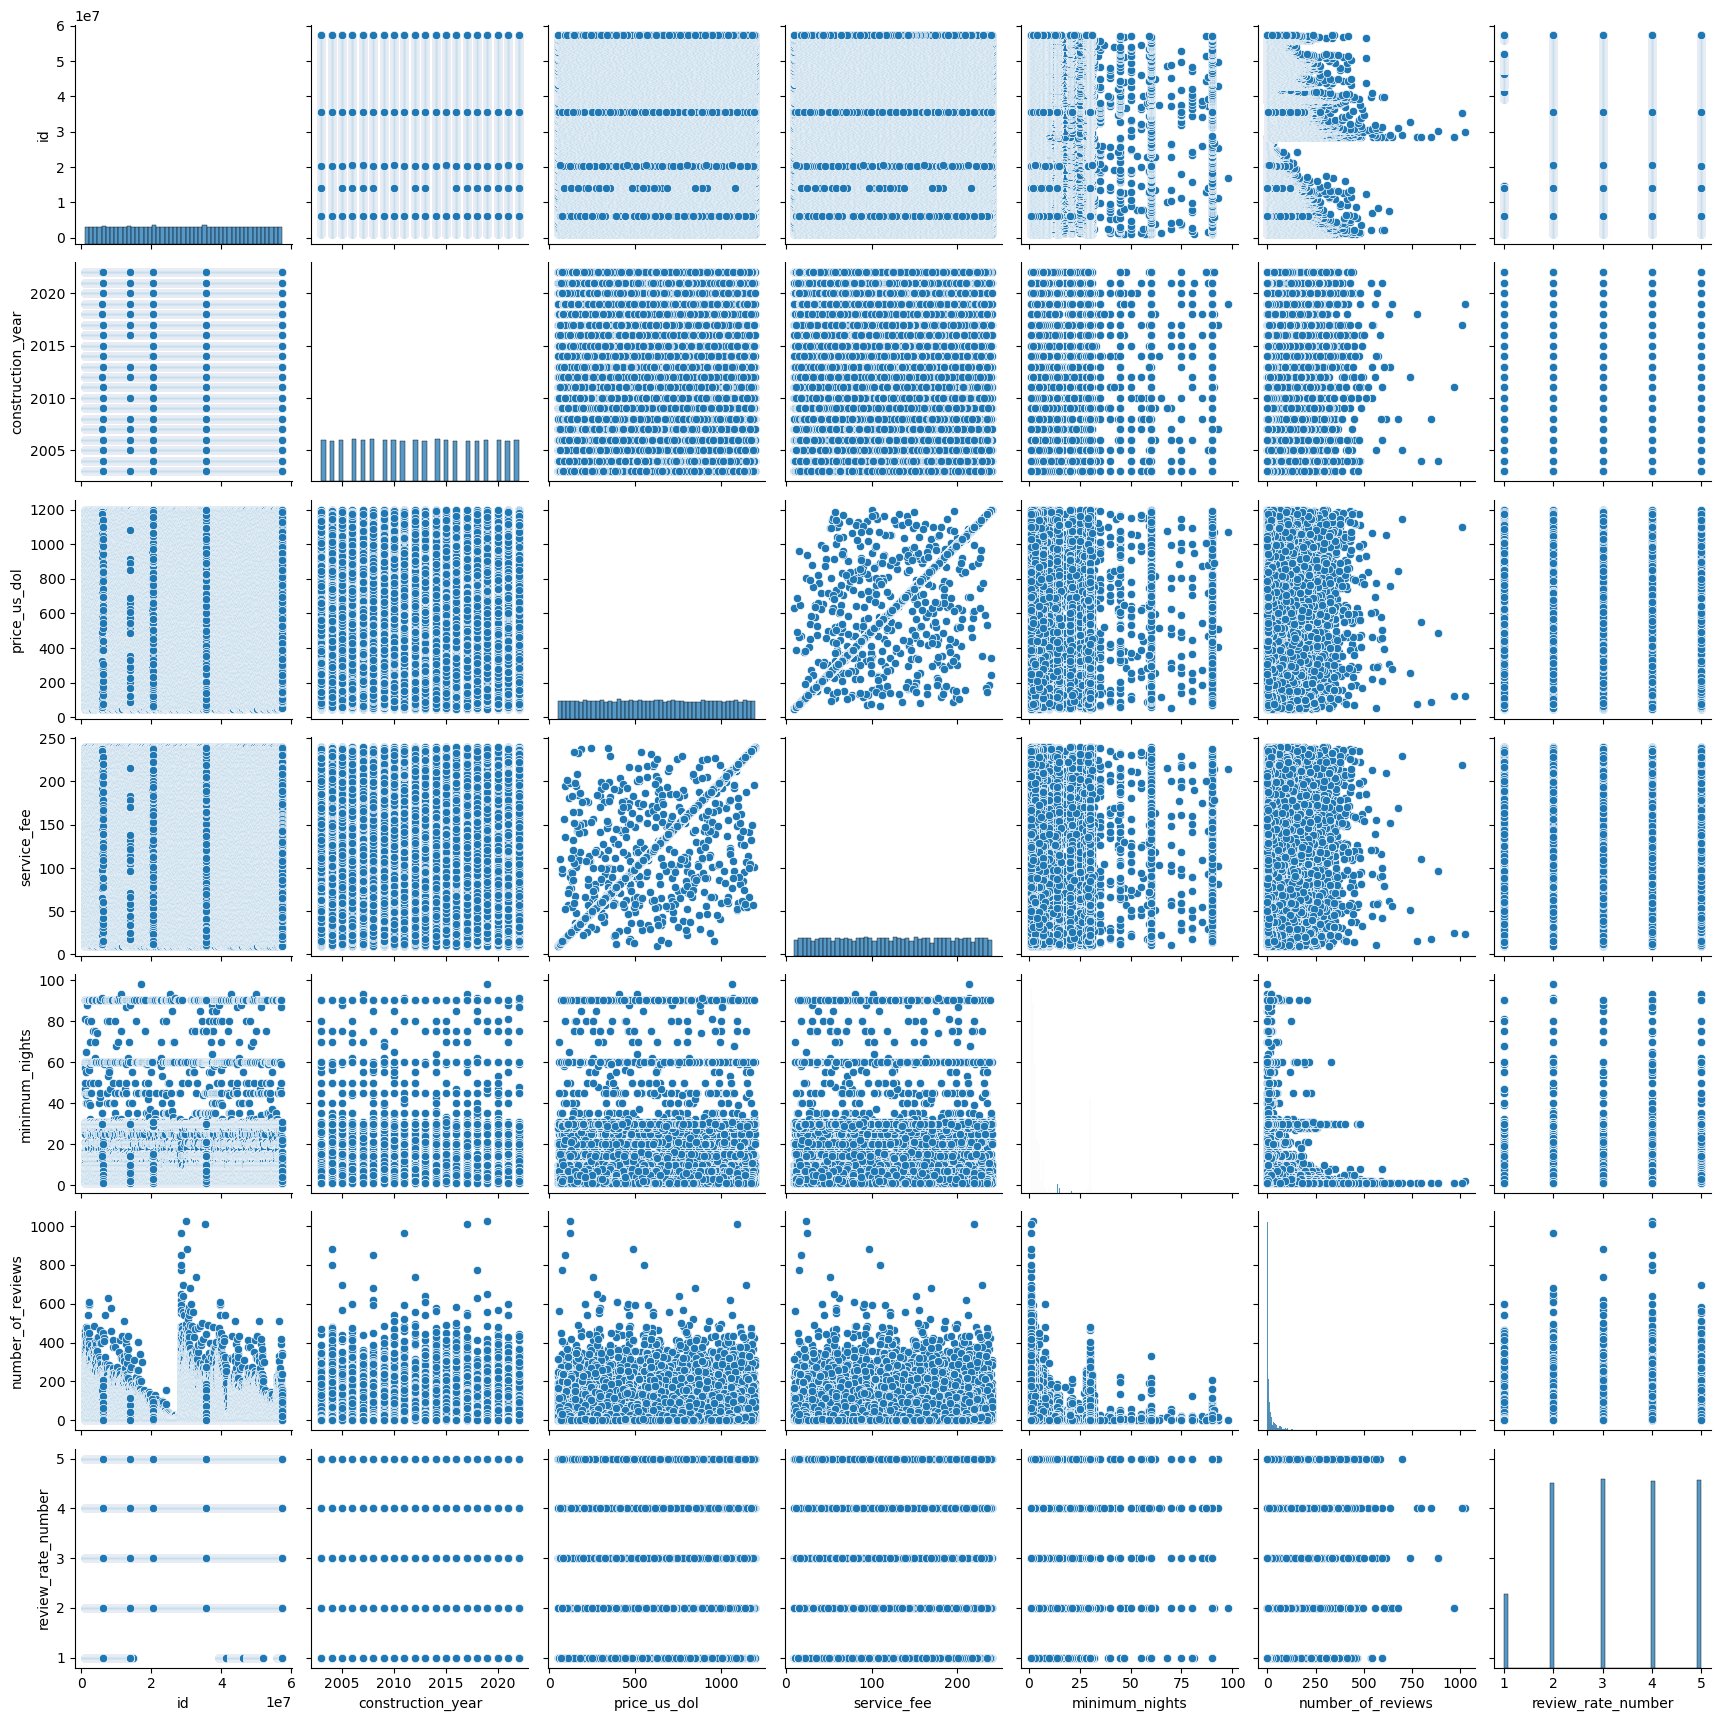

In [86]:
sns.pairplot(data=df)

--------------

#### 2.6 Correlations (Pearson and Spearman) of continuous variables..


The heatmaps display the correlation coefficients with a colour code indicating a positive and negative correlation. The report concludes a high correlation between price and service fee however no correlation was found with the other variables. 7 accommodations have a number of reviews above 700.


no correlation found

In [87]:
df.corr(method="pearson")

id  construction_year  price_us_dol  service_fee  \
id                  1.000000           0.000889      0.006987     0.007437   
construction_year   0.000889           1.000000     -0.004098    -0.003575   
price_us_dol        0.006987          -0.004098      1.000000     0.996448   
service_fee         0.007437          -0.003575      0.996448     1.000000   
minimum_nights      0.040471          -0.004165     -0.004127    -0.003903   
number_of_reviews  -0.041047           0.002375      0.005237     0.005335   
review_rate_number  0.036430           0.004660     -0.004342    -0.004072   

                    minimum_nights  number_of_reviews  review_rate_number  
id                        0.040471          -0.041047            0.036430  
construction_year        -0.004165           0.002375            0.004660  
price_us_dol             -0.004127           0.005237           -0.004342  
service_fee              -0.003903           0.005335           -0.004072  
minimum_nights            1.000000          -0.114916            0.020611  
number_of_reviews        -0.114916           1.000000           -0.018901  
review_rate_number        0.020611          -0.018901            1.000000

In [88]:
df.corr(method="spearman")

id  construction_year  price_us_dol  service_fee  \
id                  1.000000           0.000875      0.006965     0.007416   
construction_year   0.000875           1.000000     -0.004097    -0.003579   
price_us_dol        0.006965          -0.004097      1.000000     0.996444   
service_fee         0.007416          -0.003579      0.996444     1.000000   
minimum_nights      0.019593          -0.003289     -0.004318    -0.004117   
number_of_reviews   0.008391           0.001487      0.004626     0.004653   
review_rate_number  0.033364           0.005483     -0.004455    -0.004195   

                    minimum_nights  number_of_reviews  review_rate_number  
id                        0.019593           0.008391            0.033364  
construction_year        -0.003289           0.001487            0.005483  
price_us_dol             -0.004318           0.004626           -0.004455  
service_fee              -0.004117           0.004653           -0.004195  
minimum_nights            1.000000          -0.164964            0.004420  
number_of_reviews        -0.164964           1.000000           -0.014777  
review_rate_number        0.004420          -0.014777            1.000000

In [89]:
df_corr_pearson = df.corr(method="pearson")
df_corr_spearman = df.corr(method="spearman")

##### 2.6.1 Pearsons correlation


<AxesSubplot:>

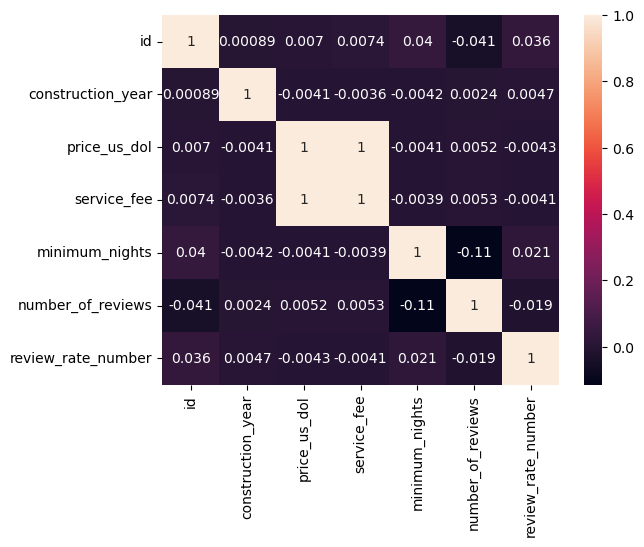

In [90]:
sns.heatmap(data=df_corr_pearson, annot=True)

##### 2.6.2 Spearman correlation

<AxesSubplot:>

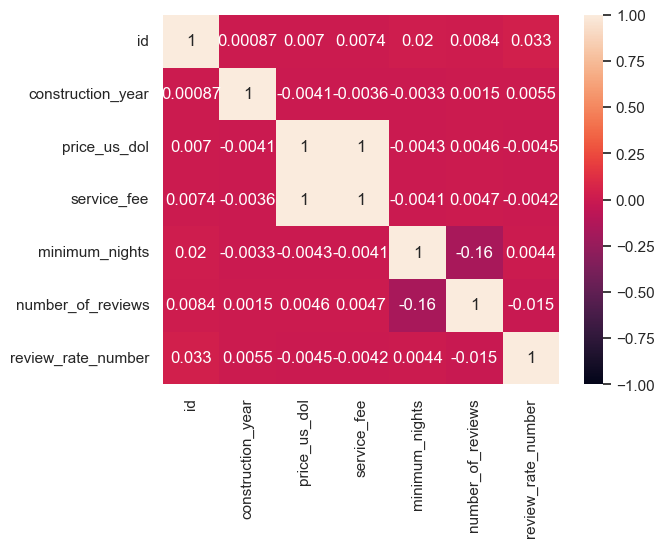

In [91]:
sns.set(font_scale=1)
sns.heatmap(data=df_corr_spearman, annot=True,vmin=-1, 
    vmax=1,)

## 3.0 Data preparation 

In [92]:
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import train_test_split

from scipy import stats
from sklearn.preprocessing import StandardScaler

In [93]:
df_pt2 = df.copy()

In [94]:
df_pt2

id host_identity_verified neighbourhood_group  \
0       1001254            unconfirmed            brooklyn   
1       1002102               verified           manhattan   
2       1002403              confirmed           manhattan   
3       1002755            unconfirmed            brooklyn   
4       1003689               verified           manhattan   
...         ...                    ...                 ...   
102594  6092437               verified            brooklyn   
102595  6092990            unconfirmed           manhattan   
102596  6093542            unconfirmed            brooklyn   
102597  6094094            unconfirmed              queens   
102598  6094647            unconfirmed           manhattan   

       cancellation_policy        room_type  construction_year  price_us_dol  \
0                   strict     private room               2020         966.0   
1                 moderate  entire home/apt               2007         142.0   
2                 flexible     private room               2005         620.0   
3                 moderate  entire home/apt               2005         368.0   
4                 moderate  entire home/apt               2009         204.0   
...                    ...              ...                ...           ...   
102594            flexible     private room               2003         844.0   
102595            moderate     private room               2016         837.0   
102596            moderate     private room               2009         988.0   
102597              strict  entire home/apt               2015         546.0   
102598            flexible  entire home/apt               2010        1032.0   

        service_fee  minimum_nights  number_of_reviews  review_rate_number  
0             193.0              10                  9                   4  
1              28.0              30                 45                   4  
2             124.0               3                  0                   5  
3              74.0              30                270                   4  
4              41.0              10                  9                   3  
...             ...             ...                ...                 ...  
102594        169.0               1                  0                   3  
102595        167.0               1                  1                   2  
102596        198.0               3                  0                   5  
102597        109.0               2                  5                   3  
102598        206.0               1                  0                   3  

[102182 rows x 11 columns]

In [95]:
df_pt2.drop(["id"], axis=1, inplace=True)

In [96]:
df_pt2

host_identity_verified neighbourhood_group cancellation_policy  \
0                 unconfirmed            brooklyn              strict   
1                    verified           manhattan            moderate   
2                   confirmed           manhattan            flexible   
3                 unconfirmed            brooklyn            moderate   
4                    verified           manhattan            moderate   
...                       ...                 ...                 ...   
102594               verified            brooklyn            flexible   
102595            unconfirmed           manhattan            moderate   
102596            unconfirmed            brooklyn            moderate   
102597            unconfirmed              queens              strict   
102598            unconfirmed           manhattan            flexible   

              room_type  construction_year  price_us_dol  service_fee  \
0          private room               2020         966.0        193.0   
1       entire home/apt               2007         142.0         28.0   
2          private room               2005         620.0        124.0   
3       entire home/apt               2005         368.0         74.0   
4       entire home/apt               2009         204.0         41.0   
...                 ...                ...           ...          ...   
102594     private room               2003         844.0        169.0   
102595     private room               2016         837.0        167.0   
102596     private room               2009         988.0        198.0   
102597  entire home/apt               2015         546.0        109.0   
102598  entire home/apt               2010        1032.0        206.0   

        minimum_nights  number_of_reviews  review_rate_number  
0                   10                  9                   4  
1                   30                 45                   4  
2                    3                  0                   5  
3                   30                270                   4  
4                   10                  9                   3  
...                ...                ...                 ...  
102594               1                  0                   3  
102595               1                  1                   2  
102596               3                  0                   5  
102597               2                  5                   3  
102598               1                  0                   3  

[102182 rows x 10 columns]

#### 3.1 dummy encoding 

Ridge and LASSO regressions require numeric values to perform computations. The “AirBnB” dataset contains categorical data, which has to be encoded first. 
One of the most common pre-processing techniques that were used is “Dummy Variable Encoding” which creates new columns that represent nominal and ordinal data by 1 and 0, or True and False and drops the first column. One-Hot encoding has also been performed; however, it seems like dummy variable encoding works better with this dataset—the data frame after encoding contains 17 columns. 

In [97]:
df_pt2_encoded = pd.get_dummies(
data=df_pt2,
drop_first=True
)

df_pt2_encoded

construction_year  price_us_dol  service_fee  minimum_nights  \
0                    2020         966.0        193.0              10   
1                    2007         142.0         28.0              30   
2                    2005         620.0        124.0               3   
3                    2005         368.0         74.0              30   
4                    2009         204.0         41.0              10   
...                   ...           ...          ...             ...   
102594               2003         844.0        169.0               1   
102595               2016         837.0        167.0               1   
102596               2009         988.0        198.0               3   
102597               2015         546.0        109.0               2   
102598               2010        1032.0        206.0               1   

        number_of_reviews  review_rate_number  \
0                       9                   4   
1                      45                   4   
2                       0                   5   
3                     270                   4   
4                       9                   3   
...                   ...                 ...   
102594                  0                   3   
102595                  1                   2   
102596                  0                   5   
102597                  5                   3   
102598                  0                   3   

        host_identity_verified_unconfirmed  host_identity_verified_verified  \
0                                        1                                0   
1                                        0                                1   
2                                        0                                0   
3                                        1                                0   
4                                        0                                1   
...                                    ...                              ...   
102594                                   0                                1   
102595                                   1                                0   
102596                                   1                                0   
102597                                   1                                0   
102598                                   1                                0   

        neighbourhood_group_brooklyn  neighbourhood_group_manhattan  \
0                                  1                              0   
1                                  0                              1   
2                                  0                              1   
3                                  1                              0   
4                                  0                              1   
...                              ...                            ...   
102594                             1                              0   
102595                             0                              1   
102596                             1                              0   
102597                             0                              0   
102598                             0                              1   

        neighbourhood_group_queens  neighbourhood_group_staten island  \
0                                0                                  0   
1                                0                                  0   
2                                0                                  0   
3                                0                                  0   
4                                0                                  0   
...                            ...                                ...   
102594                           0                                  0   
102595                           0                                  0   
102596                           0                                  0   
102597                

#### 3.2 train/split partitions with the ratio of 70/30

After data frame encoding, the partitions of the dataset (train and test partitions) need to be created to avoid overfitting the model. 
As the “df_pt2” dataset contains over one hundred thousand rows, the split ratio is 70/30 per cent (test size test, train), including random state to keep outcomes the same every time the model ran.



In [98]:
train_1, test_1 = train_test_split(
df_pt2_encoded,
test_size = 0.3,
random_state=42
)

In [99]:
test_1

construction_year  price_us_dol  service_fee  minimum_nights  \
34022               2018         292.0         58.0              30   
82993               2010         383.0         77.0               2   
834                 2019         659.0        132.0               3   
99779               2005        1000.0        200.0               2   
36576               2020         912.0        182.0               3   
...                  ...           ...          ...             ...   
80854               2013         203.0         41.0              10   
68173               2016         390.0         78.0              30   
61761               2020         989.0        198.0               1   
68318               2010         608.0        122.0               2   
95940               2021         569.0        114.0               1   

       number_of_reviews  review_rate_number  \
34022                  0                   2   
82993                 16                   4   
834                   23                   4   
99779                 90                   5   
36576                  2                   3   
...                  ...                 ...   
80854                 17                   1   
68173                 74                   2   
61761                  1                   4   
68318                 48                   4   
95940                 36                   3   

       host_identity_verified_unconfirmed  host_identity_verified_verified  \
34022                                   0                                1   
82993                                   1                                0   
834                                     0                                1   
99779                                   0                                1   
36576                                   1                                0   
...                                   ...                              ...   
80854                                   0                                1   
68173                                   0                                1   
61761                                   1                                0   
68318                                   0                                1   
95940                                   1                                0   

       neighbourhood_group_brooklyn  neighbourhood_group_manhattan  \
34022                             0                              1   
82993                             0                              0   
834                               1                              0   
99779                             0                              1   
36576                             0                              0   
...                             ...                            ...   
80854                             0                              1   
68173                             1                              0   
61761                             1                              0   
68318                             1                              0   
95940                             1                              0   

       neighbourhood_group_queens  neighbourhood_group_staten island  \
34022                           0                                  0   
82993                           0                                  0   
834                             0                                  0   
99779                           0                                  0   
36576                           1                                  0   
...                           ...                                ...   
80854                           0                                  0   
68173                           0                                  0   
61761                           0                                  0   
68318                           0                                  0   
95940  

#### 3.3 Dependent and independent variable partitions

Further split has been performed to separate dependent (price_usd_dol) and independent variables between train and test partitions.


In [100]:
df_pt2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102182 entries, 0 to 102598
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   host_identity_verified  102182 non-null  object 
 1   neighbourhood_group     102182 non-null  object 
 2   cancellation_policy     102182 non-null  object 
 3   room_type               102182 non-null  object 
 4   construction_year       102182 non-null  int32  
 5   price_us_dol            102182 non-null  float64
 6   service_fee             102182 non-null  float64
 7   minimum_nights          102182 non-null  int32  
 8   number_of_reviews       102182 non-null  int32  
 9   review_rate_number      102182 non-null  int32  
dtypes: float64(2), int32(4), object(4)
memory usage: 11.0+ MB


In [101]:
X_train_1 = train_1.drop(
['price_us_dol'],
axis=1
)

y_train_1 = train_1.filter(['price_us_dol'])

In [102]:
X_test_1 = test_1.drop(
['price_us_dol'],
axis=1
)

y_test_1 = test_1.filter(['price_us_dol'])

#### 3.4 Mean Absolute error range

Before building the model and performing a calculation, the range of dependent variables was calculated for MAE scores interpretation.

In [103]:
y_range = y_test_1.max() - y_test_1.min()
y_range

price_us_dol    1150.0
dtype: float64

----------------

## 4.0 Test 1: Regressions (main test)

###  Ridge regression

The first step of the modelling is the determination of hyperparameter – alpha (lambda). It is the amount of L2 penalty applied to the model responsible for the strength of the regularisation. Ridge regression penalises the coefficients by removing the mean and scaling each dataset feature to unit variance (Scikitlearn, 2023).  In the model, the penalisation used is very small (10**-10). 

Data will be scalled as model works better.

In [104]:
ridge_model = Ridge(alpha=10**-10)
scaler = StandardScaler()
cv = RepeatedKFold(
n_splits=10,
n_repeats=3,         
random_state=42
)

#### 4.1 Data scaling and MAE cross validation

Data has been standardised using “StandardScaler”. After multiple attempts, the model performance improved once the data had been standardised. In the same appendix, cross-validation has been applied to compute mean absolute error (cross_val_score). 

The mean absolute error across equals ≈ 3.152 (out of range 1150) or around 0.2741% of the range in the dependent variable. Please note that this is a result of an unregulated model.


In [105]:
X_train_scaled = scaler.fit_transform(X_train_1)
X_test_scaled = scaler.transform(X_test_1)

In [106]:
MAE = cross_val_score(
ridge_model,
X_train_scaled,
y_train_1,
scoring="neg_mean_absolute_error",
cv=cv,
n_jobs=-1   # use as many pc cores as possible, we can use just 2
)

In [107]:
MAE = np.absolute(MAE)
print("Average MAE: {:.3f} ({:.3f})".format(np.mean(MAE), np.std(MAE)))

Average MAE: 3.152 (0.276)


The average mean absolute error across all folds is ≈ 3.064 (out of range 1150) or around 0.2664% of the range
in the dependent variable.

In [108]:
##### This is the result for an unregularised model. Let’s try building a regularised model

#### 4.2 Alpha (lambda) tuning and grid search

To perform a regulated model, alpha tune_grid computation has been created  Next, GridSearchCV tested all possible combinations specified in tune_grid to find the best hyperparameter and evaluated by negative mean absolute error, including a pre-defined cross-validation check.

--------------
created with a range of values between 4 and 16 steps by 1 
Note: This range was arrived at by trial and error.

In [109]:
tune_grid = dict()
tune_grid['alpha'] = [(x/500) for x in list(range(4,16,1))]
tune_grid

{'alpha': [0.008,
  0.01,
  0.012,
  0.014,
  0.016,
  0.018,
  0.02,
  0.022,
  0.024,
  0.026,
  0.028,
  0.03]}

Now we run the grid search, creating and evaluating a model for each 𝜆 (named alpha) value
in the grid. Expect this to take a few minutes to complete!

In [110]:
tune = GridSearchCV(
ridge_model,
tune_grid,
scoring='neg_mean_absolute_error',
cv=cv
)

tune_results = tune.fit(
X_train_scaled,
y_train_1
)

In [111]:
# now we have best MAE and alpha to use for this dataset

In [112]:
print('MAE: {:.3f}'.format(-tune_results.best_score_))
print('Parameters: {}'.format(tune_results.best_params_))

MAE: 3.152
Parameters: {'alpha': 0.008}


#### 4.3 Ridge regression train, prediction and coefficent

In the process above, the most optimal alpha has been specified as 0.008, used for the Ridge model. 
The model has been fitted with scaled X_train and y-train variables and computed predictions for our dependent variable using scaled X_test variable. MEA score improved from 3.152 to 2.967 compared to the unregulated model. 

In [113]:
ridge = Ridge(alpha=0.008)
ridge.fit(X_train_scaled, y_train_1)
y_predicted1 = ridge.predict(X_test_scaled)
print('Test MAE: {:3f}'.format(mean_absolute_error(y_test_1,y_predicted1)))

Test MAE: 2.967458


In [114]:
# variable creation for plot purposes only

In [115]:
y_predicted1

array([[290.2607348 ],
       [385.8618724 ],
       [659.96194501],
       ...,
       [989.12660024],
       [609.90944215],
       [570.15226577]])

In [116]:
pred_for_chart = y_predicted1.copy()

In [117]:
pred_for_chart = pd.Series(pred_for_chart.flatten())

In [118]:
pred_for_chart

0        290.260735
1        385.861872
2        659.961945
3        998.129299
4        908.688734
            ...    
30650    205.864401
30651    390.835832
30652    989.126600
30653    609.909442
30654    570.152266
Length: 30655, dtype: float64

-------------


Each coefficient represents the change in the dependent variable, "price_us_dol", associated with a one-unit change in each independent variable

In [119]:
coef = ridge.coef_
coefficients = {X_train_1.columns[i]: coef[0][i]
                for i in range(len(X_train_1.columns))}
coefficients

{'construction_year': -0.21911941613820843,
 'service_fee': 329.7807538516073,
 'minimum_nights': -0.1368051033527464,
 'number_of_reviews': -0.05125105118237476,
 'review_rate_number': -0.06803424124743962,
 'host_identity_verified_unconfirmed': 1.1344523782814764,
 'host_identity_verified_verified': 1.0038194086797194,
 'neighbourhood_group_brooklyn': 0.07328770028375588,
 'neighbourhood_group_manhattan': -0.1609846200377306,
 'neighbourhood_group_queens': 0.011721691783105165,
 'neighbourhood_group_staten island': 0.042875258471759214,
 'cancellation_policy_moderate': 0.03650182639971114,
 'cancellation_policy_strict': -0.08383166721013499,
 'room_type_hotel room': 0.007003821095674267,
 'room_type_private room': -0.19044660658377002,
 'room_type_shared room': -0.18394930010717497}

## LASSO regression

LASSO regression uses the L1 type of penalisation. The main difference from L2 penalisation in Ridge Regression is that the L1 penalty type can lead the coefficients towards exactly zero; some of the features can be entirely excluded from the model.

As pre-processing part has been performed for ridge regression above, it has also been used for LASSO regression as the model ran just after the Ridge regression and contained the same train/test variables.

The first step is LASSO model creation with optimisation of model tolerance to 1e-2, and a maximum number of iterations equals 2000.

In [120]:
lasso_model = Lasso(
tol=1e-2,           # The tolerance for the optimization: if the updates are smaller than tol, the optimization code checks the dual gap for optimality and continues until it is smaller than tol.
max_iter=2000       # The maximum number of iterations.
)

#### 4.4 k-fold cross validation

For LASSO regression, apart from grid search, repeated k-fold has also been performed to obtain more reliable estimates of the model performance. A k-fold will split the data frame into the train and validation sets ten times, which will be repeated three times

In [121]:
cv = RepeatedKFold(
n_splits=10,
n_repeats=3,
random_state=42
)

#### 4.5 Alpha (lambda ) tuning and grid search

Similar to the Ridge regression tune grid computation with a range of values between 1-45 stepping by 5 to find the most optimal alpha that could be used for optimal penalisation. Once tune_grid has been calculated, GridSearch cross-validation has been applied with negative mean absolute error scoring similar to the ridge regression; however, ReapetedKFold has been used for the cross-validation generator. Another step was the standardisation of the X_train and y_train variables before fitting them to the model for predictions

In [122]:
tune_grid = dict()
tune_grid['alpha'] = [(x/100) for x in list(range(1,45,5))]
tune_grid

{'alpha': [0.01, 0.06, 0.11, 0.16, 0.21, 0.26, 0.31, 0.36, 0.41]}

In [123]:
tune = GridSearchCV(
lasso_model,
tune_grid,
scoring='neg_mean_absolute_error',
cv=cv
)
tune_results = tune.fit(
StandardScaler().fit_transform(X_train_1),y_train_1
)

In [124]:
print('MAE: {:.3f}'.format(-tune_results.best_score_))
print('Parameters: {}'.format(tune_results.best_params_))

MAE: 3.147
Parameters: {'alpha': 0.01}


#### 4.6 Lasso regression train, prediction and coefficent

In this step, lasso regression has been trained using an alpha hyperparameter of 0.00055 regardless of the outcome of grid search computation. Due to multiple performed tests, the alpha of 0.00055 MAE outcome is smaller than suggested by grid search 0.01.

Once scaled data has fit the model, MAE outcome improved to 2.965, and predictions are ready for analysis.

In [125]:
lasso = Lasso(alpha=0.00055,max_iter=5000)
lasso.fit(X_train_1, y_train_1)
y_predicted = lasso.predict(X_test_1)
print('Test MAE: {:3f}'.format(mean_absolute_error(y_test_1,y_predicted)))

Test MAE: 2.965489


The coefficient indicates the straight direction of the dependent (price_us_dol) variable

In [126]:
coef = lasso.coef_
coefficients = {X_train_1.columns[i]: coef[i]
                for i in range(len(X_train_1.columns))}
coefficients

{'construction_year': -0.03794279473333933,
 'service_fee': 4.982064101047693,
 'minimum_nights': -0.01254336455683189,
 'number_of_reviews': -0.0010330941483176908,
 'review_rate_number': -0.05260265828565304,
 'host_identity_verified_unconfirmed': 1.781527217414901,
 'host_identity_verified_verified': 1.520454059000769,
 'neighbourhood_group_brooklyn': 0.11514914474190302,
 'neighbourhood_group_manhattan': -0.3557464203832517,
 'neighbourhood_group_queens': 0.0,
 'neighbourhood_group_staten island': 0.3541692441384111,
 'cancellation_policy_moderate': 0.07583261721573124,
 'cancellation_policy_strict': -0.17597880122288148,
 'room_type_hotel room': 0.0,
 'room_type_private room': -0.3793080972816598,
 'room_type_shared room': -1.2505646110395627}

## Places rated data (PCA)

PCA is an unsupervised technique that reduces dimensionality (features) in a given dataset, enhances interpretability and minimises information loss. Using PCA, a sequence of linear combinations of variables can be found.

In [127]:
from sklearn import preprocessing
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.linalg as la 

First data has to be dummy encoded however it was done in previous part of the code

In [128]:
df_pt2_encoded.head()

construction_year  price_us_dol  service_fee  minimum_nights  \
0               2020         966.0        193.0              10   
1               2007         142.0         28.0              30   
2               2005         620.0        124.0               3   
3               2005         368.0         74.0              30   
4               2009         204.0         41.0              10   

   number_of_reviews  review_rate_number  host_identity_verified_unconfirmed  \
0                  9                   4                                   1   
1                 45                   4                                   0   
2                  0                   5                                   0   
3                270                   4                                   1   
4                  9                   3                                   0   

   host_identity_verified_verified  neighbourhood_group_brooklyn  \
0                                0                             1   
1                                1                             0   
2                                0                             0   
3                                0                             1   
4                                1                             0   

   neighbourhood_group_manhattan  neighbourhood_group_queens  \
0                              0                           0   
1                              1                           0   
2                              1                           0   
3                              0                           0   
4                              1                           0   

   neighbourhood_group_staten island  cancellation_policy_moderate  \
0                                  0                             0   
1                                  0                             1   
2                                  0                             0   
3                                  0                             1   
4                                  0                             1   

   cancellation_policy_strict  room_type_hotel room  room_type_private room  \
0                           1                     0                       1   
1                           0                     0                       0   
2                           0                     0                       1   
3                           0                     0                       0   
4                           0                     0                       0   

   room_type_shared room  
0                      0  
1                      0  
2                      0  
3                      0  
4                      0

Removing dependant variable from the dataset before running PCA model

In [129]:
df_pt2_encoded.drop(["price_us_dol"],axis=1, inplace=True)

#### 4.7 Data scalling

The first part of the process is data scaling. In this model, the function will only subtract each feature mean but won not divide by its standard deviation due to model outcomes failure 



In [130]:
places_data_standardised = preprocessing.scale(
    df_pt2_encoded,
    with_std = False
)

Standardised the data provide wrong outcomes therefore in this PCA it has not been done, we can now run the Principal Components Analysis.

#### 4.8 Data transformation and principal components computation

With transformed data, the same number of observations is represented by a smaller number of principal components that capture most of the variance in the original data.

Data transformed in this way can be used for further analysis or visualisation, such as clustering or plotting in a lower-dimensional space.


In [131]:
pca = PCA()
fit = pca.fit_transform(places_data_standardised)

#### 4.9 Eigenvectors and eigenvalues

Principal components are created by combining the original features into linear combinations using eigenvectors and eigenvalues. Each subsequent principal component explains the remaining variation in the data that is not correlated to the previous component and the first principal component.

In [132]:
pca.explained_variance_

array([4.39237085e+03, 2.45045837e+03, 1.18187954e+02, 3.32436087e+01,
       1.64383178e+00, 4.98585118e-01, 4.18827597e-01, 3.33808166e-01,
       2.44244207e-01, 1.64017919e-01, 1.10931871e-01, 2.06936948e-02,
       1.54550111e-02, 5.03663266e-03, 1.37556246e-03, 1.12994561e-03])

In this code, pca.explained_variance_ratio_ retrieves the amount of variance explained by each principal component calculated by the PCA object, relative to the original variance.

In [133]:
pca.explained_variance_ratio_

array([6.27686111e-01, 3.50179604e-01, 1.68894977e-02, 4.75063518e-03,
       2.34909668e-04, 7.12496655e-05, 5.98520195e-05, 4.77024270e-05,
       3.49034045e-05, 2.34387699e-05, 1.58525764e-05, 2.95720587e-06,
       2.20857850e-06, 7.19753517e-07, 1.96572986e-07, 1.61473426e-07])

Interpreted as follows:

    Principal component 1 explains approximately 62.77% of the variance in the data
    Principal component 2 explains a further 35.02% (approximately) of the variance in the data

So to perform the prediction columns construction_year and service_fee are the most crucial in about 97%

#### 4.9.1 PCA the first component outcome
This array represents the weight of each feature in the original dataset in the first principal component.

In [134]:
pca.components_[0,]

array([-3.11929626e-04,  9.99958866e-01, -7.94355860e-04,  9.02905824e-03,
       -8.13542677e-05,  3.26528172e-05, -3.42836315e-05,  2.22627337e-05,
       -5.45132749e-05,  2.93906653e-05, -1.80217474e-07, -4.42463254e-06,
       -1.04354921e-05,  1.98717970e-06, -2.30187401e-06,  7.32813735e-06])

Text(0, 0.5, 'Eigenvalue')

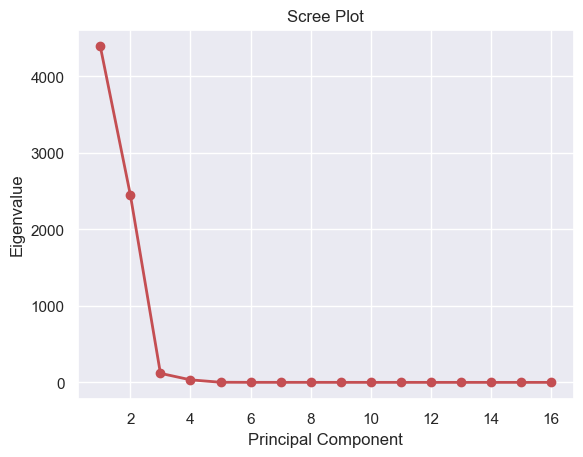

In [135]:
principal_component_number = np.arange(16) + 1 # number of variables + 1
plt.plot(
    principal_component_number,            # x axis
    pca.explained_variance_,               # y axis
    'ro-',                               # r - red, o - dosts, dash spec line
    linewidth=2                          # line width
)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')

## Test 2 : The same models as above but without highly correlated with target variable: service_fee column

The same alpha has been used as above to have 1:1 comparisement

### Preperation 

In [136]:
df_pt2_2 = df.copy()
df_pt2_2.drop(["id","service_fee"], axis=1,inplace=True)

In [137]:
df_pt2_2

host_identity_verified neighbourhood_group cancellation_policy  \
0                 unconfirmed            brooklyn              strict   
1                    verified           manhattan            moderate   
2                   confirmed           manhattan            flexible   
3                 unconfirmed            brooklyn            moderate   
4                    verified           manhattan            moderate   
...                       ...                 ...                 ...   
102594               verified            brooklyn            flexible   
102595            unconfirmed           manhattan            moderate   
102596            unconfirmed            brooklyn            moderate   
102597            unconfirmed              queens              strict   
102598            unconfirmed           manhattan            flexible   

              room_type  construction_year  price_us_dol  minimum_nights  \
0          private room               2020         966.0              10   
1       entire home/apt               2007         142.0              30   
2          private room               2005         620.0               3   
3       entire home/apt               2005         368.0              30   
4       entire home/apt               2009         204.0              10   
...                 ...                ...           ...             ...   
102594     private room               2003         844.0               1   
102595     private room               2016         837.0               1   
102596     private room               2009         988.0               3   
102597  entire home/apt               2015         546.0               2   
102598  entire home/apt               2010        1032.0               1   

        number_of_reviews  review_rate_number  
0                       9                   4  
1                      45                   4  
2                       0                   5  
3                     270                   4  
4                       9                   3  
...                   ...                 ...  
102594                  0                   3  
102595                  1                   2  
102596                  0                   5  
102597                  5                   3  
102598                  0                   3  

[102182 rows x 9 columns]

In [138]:
df_pt2_2_encoded = pd.get_dummies(
data=df_pt2_2,
drop_first=True
)

df_pt2_2_encoded

construction_year  price_us_dol  minimum_nights  number_of_reviews  \
0                    2020         966.0              10                  9   
1                    2007         142.0              30                 45   
2                    2005         620.0               3                  0   
3                    2005         368.0              30                270   
4                    2009         204.0              10                  9   
...                   ...           ...             ...                ...   
102594               2003         844.0               1                  0   
102595               2016         837.0               1                  1   
102596               2009         988.0               3                  0   
102597               2015         546.0               2                  5   
102598               2010        1032.0               1                  0   

        review_rate_number  host_identity_verified_unconfirmed  \
0                        4                                   1   
1                        4                                   0   
2                        5                                   0   
3                        4                                   1   
4                        3                                   0   
...                    ...                                 ...   
102594                   3                                   0   
102595                   2                                   1   
102596                   5                                   1   
102597                   3                                   1   
102598                   3                                   1   

        host_identity_verified_verified  neighbourhood_group_brooklyn  \
0                                     0                             1   
1                                     1                             0   
2                                     0                             0   
3                                     0                             1   
4                                     1                             0   
...                                 ...                           ...   
102594                                1                             1   
102595                                0                             0   
102596                                0                             1   
102597                                0                             0   
102598                                0                             0   

        neighbourhood_group_manhattan  neighbourhood_group_queens  \
0                                   0                           0   
1                                   1                           0   
2                                   1                           0   
3                                   0                           0   
4                                   1                           0   
...                               ...                         ...   
102594                              0                           0   
102595                              1                           0   
102596                              0                           0   
102597                              0                           1   
102598                              1                           0   

        neighbourhood_group_staten island  cancellation_policy_moderate  \
0                                       0                             0   
1                                       0                             1   
2                                       0                             0   
3                                       0                             1   
4                                       0                             1   
...                                   ...                           ...   
102594                                  0      

In [139]:
train, test = train_test_split(
df_pt2_2_encoded,
test_size = 0.2,
random_state=42
)

In [140]:
X_train = train.drop(
['price_us_dol'],
axis=1
)

y_train = train.filter(['price_us_dol'])

In [141]:
X_test = test.drop(
['price_us_dol'],
axis=1
)

y_test = test.filter(['price_us_dol'])

In [142]:
y_range = y_test.max() - y_test.min()
y_range

price_us_dol    1150.0
dtype: float64

### Ridge regression

In [143]:
ridge_model = Ridge(alpha=10**-10)
scaler = StandardScaler()
cv = RepeatedKFold(
n_splits=10,
n_repeats=3,         
random_state=42
)

In [144]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [145]:
MAE = cross_val_score(
ridge_model,
X_train_scaled,
y_train,
scoring="neg_mean_absolute_error",
cv=cv,
n_jobs=-1   # use as many pc cores as possible, we can use just 2
)

In [146]:
MAE = np.absolute(MAE)
print("Average MAE: {:.3f} ({:.3f})".format(np.mean(MAE), np.std(MAE)))

Average MAE: 286.490 (1.886)


In [147]:
tune_grid = dict()
tune_grid['alpha'] = [x/500 for x in list(range(4,26,1))]
tune_grid

{'alpha': [0.008,
  0.01,
  0.012,
  0.014,
  0.016,
  0.018,
  0.02,
  0.022,
  0.024,
  0.026,
  0.028,
  0.03,
  0.032,
  0.034,
  0.036,
  0.038,
  0.04,
  0.042,
  0.044,
  0.046,
  0.048,
  0.05]}

In [148]:
tune = GridSearchCV(
    ridge_model,
    tune_grid,
    scoring='neg_mean_absolute_error',
    cv=cv
)

tune_results = tune.fit(
X_train_scaled,
y_train
)

In [149]:
print('MAE: {:.3f}'.format(-tune_results.best_score_))
print('Parameters: {}'.format(tune_results.best_params_))

MAE: 286.490
Parameters: {'alpha': 0.05}


In [150]:
ridge = Ridge(alpha=0.008)
ridge.fit(X_train_scaled, y_train)
y_predicted = ridge.predict(X_test_scaled)
print('Test MAE: {:3f}'.format(mean_absolute_error(y_test,y_predicted)))

Test MAE: 287.362152


In [151]:
y_predicted

array([[619.43463738],
       [622.70219461],
       [625.53821021],
       ...,
       [627.09386304],
       [620.53666788],
       [622.86729062]])

In [152]:
coef = ridge.coef_
coefficients = {X_train.columns[i]: coef[0][i]
                for i in range(len(X_train.columns))}
coefficients

{'construction_year': -0.6693315026611688,
 'minimum_nights': -0.49269369455348155,
 'number_of_reviews': 1.920910639070576,
 'review_rate_number': -0.5555761862217482,
 'host_identity_verified_unconfirmed': -2.35134561442133,
 'host_identity_verified_verified': -3.2599488159197736,
 'neighbourhood_group_brooklyn': 0.5485934805054482,
 'neighbourhood_group_manhattan': -1.2732519593935037,
 'neighbourhood_group_queens': 1.7226386086199301,
 'neighbourhood_group_staten island': -0.21942031858713815,
 'cancellation_policy_moderate': -1.2083139190085044,
 'cancellation_policy_strict': -1.4483460236627672,
 'room_type_hotel room': 1.4641048406867234,
 'room_type_private room': -0.6403826361222225,
 'room_type_shared room': 0.7017798164331771}

-----------

## Test 3 : The same models as above but instead of full dataset with over 100k rows, sampled data will be used.

**As dependent variable is highly corelated with "service_fee" has been dropped to see if performance would be better as potentially cause Multicoliniarity visible in coefficents outcome**

### Preperations

In [153]:
sampled_df

id host_identity_verified neighbourhood_group cancellation_policy  \
0     1001254            unconfirmed            brooklyn              strict   
1     1002102               verified           manhattan            moderate   
2     1002403              confirmed           manhattan            flexible   
3     1002755            unconfirmed            brooklyn            moderate   
4     1003689               verified           manhattan            moderate   
...       ...                    ...                 ...                 ...   
4052  3239256               verified            brooklyn            flexible   
4053  3239808            unconfirmed            brooklyn            moderate   
4054  3240360               verified           manhattan              strict   
4055  3240913               verified           manhattan              strict   
4056  3241465            unconfirmed            brooklyn              strict   

            room_type  construction_year  price_us_dol  service_fee  \
0        private room               2020         966.0        193.0   
1     entire home/apt               2007         142.0         28.0   
2        private room               2005         620.0        124.0   
3     entire home/apt               2005         368.0         74.0   
4     entire home/apt               2009         204.0         41.0   
...               ...                ...           ...          ...   
4052  entire home/apt               2010        1081.0        216.0   
4053  entire home/apt               2016          85.0         17.0   
4054     private room               2003        1038.0        208.0   
4055     private room               2020         907.0        181.0   
4056  entire home/apt               2011         745.0        149.0   

      minimum_nights  number_of_reviews  review_rate_number  
0                 10                  9                   4  
1                 30                 45                   4  
2                  3                  0                   5  
3                 30                270                   4  
4                 10                  9                   3  
...              ...                ...                 ...  
4052               6                  6                   4  
4053              10                 40                   5  
4054               5                109                   4  
4055               3                  2                   4  
4056              14                  2                   3  

[4000 rows x 11 columns]

In [154]:
# dropping service fee to avoid multicoliniarity as positive corelation of 0.99% with price_us_dol and id which is redundant for modelinabsg

sampled_df.drop(["service_fee","id"], axis=1, inplace=True)

C:\Users\Admin\AppData\Local\Temp\ipykernel_20108\1959315928.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_df.drop(["service_fee","id"], axis=1, inplace=True)


In [155]:
small_df_encoded = pd.get_dummies(
data=sampled_df,
drop_first=True
)
small_df_encoded

construction_year  price_us_dol  minimum_nights  number_of_reviews  \
0                  2020         966.0              10                  9   
1                  2007         142.0              30                 45   
2                  2005         620.0               3                  0   
3                  2005         368.0              30                270   
4                  2009         204.0              10                  9   
...                 ...           ...             ...                ...   
4052               2010        1081.0               6                  6   
4053               2016          85.0              10                 40   
4054               2003        1038.0               5                109   
4055               2020         907.0               3                  2   
4056               2011         745.0              14                  2   

      review_rate_number  host_identity_verified_unconfirmed  \
0                      4                                   1   
1                      4                                   0   
2                      5                                   0   
3                      4                                   1   
4                      3                                   0   
...                  ...                                 ...   
4052                   4                                   0   
4053                   5                                   1   
4054                   4                                   0   
4055                   4                                   0   
4056                   3                                   1   

      host_identity_verified_verified  neighbourhood_group_brooklyn  \
0                                   0                             1   
1                                   1                             0   
2                                   0                             0   
3                                   0                             1   
4                                   1                             0   
...                               ...                           ...   
4052                                1                             1   
4053                                0                             1   
4054                                1                             0   
4055                                1                             0   
4056                                0                             1   

      neighbourhood_group_manhattan  neighbourhood_group_queens  \
0                                 0                           0   
1                                 1                           0   
2                                 1                           0   
3                                 0                           0   
4                                 1                           0   
...                             ...                         ...   
4052                              0                           0   
4053                              0                           0   
4054                              1                           0   
4055                              1                           0   
4056                              0                           0   

      neighbourhood_group_staten island  cancellation_policy_moderate  \
0                                     0                             0   
1                                     0                             1   
2                                     0                             0   
3                                     0                             1   
4                                     0                             1   
...                                 ...                           ...   
4052                                  0                             0   
4053                                  0                             1   
4054     

In [156]:
# train/split encoded dataset with split ratio 80/20

In [157]:
train, test = train_test_split(
small_df_encoded,
test_size = 0.2,
random_state=42
)

In [158]:
# further split to X - independent variables and y - dependent variables

In [159]:
X_train = train.drop(
['price_us_dol'],
axis=1
)

y_train = train.filter(['price_us_dol'])

In [160]:
X_test = test.drop(
['price_us_dol'],
axis=1
)

y_test = test.filter(['price_us_dol'])

In [161]:
# MAE range

In [162]:
y_range = y_test.max() - y_test.min()
y_range

price_us_dol    1148.0
dtype: float64

#### Ridge regression

Similar to ridge regression of full dataset , dataframs has been scaled as with this dataset the regression works better if scalled

In [163]:
ridge_model = Ridge(alpha=10**-10)
scaler = StandardScaler()
cv = RepeatedKFold(
n_splits=10,
n_repeats=3,          # for ca can be as 1 to not overuse pc
random_state=42
)

In [164]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [165]:
MAE = cross_val_score(
ridge_model,
X_train_scaled,
y_train,
scoring="neg_mean_absolute_error",
cv=cv,
n_jobs=-1   # use as many pc cores as possible, we can use just 2
)

In [166]:
MAE = np.absolute(MAE)
print("Average MAE: {:.3f} ({:.3f})".format(np.mean(MAE), np.std(MAE)))

Average MAE: 286.990 (8.103)


In [167]:
tune_grid = dict()
tune_grid['alpha'] = [(x/500) for x in list(range(4,16,1))]
tune_grid

{'alpha': [0.008,
  0.01,
  0.012,
  0.014,
  0.016,
  0.018,
  0.02,
  0.022,
  0.024,
  0.026,
  0.028,
  0.03]}

In [168]:
tune = GridSearchCV(
ridge_model,
tune_grid,
scoring='neg_mean_absolute_error',
cv=cv
)

tune_results = tune.fit(
X_train_scaled,
y_train
)

In [169]:
print('MAE: {:.3f}'.format(-tune_results.best_score_))
print('Parameters: {}'.format(tune_results.best_params_))

MAE: 286.990
Parameters: {'alpha': 0.03}


In [170]:
# we used our alpha from the above as its the best
ridge = Ridge(alpha=0.03)
ridge.fit(X_train_scaled, y_train)
y_predicted = ridge.predict(X_test)
print('Test MAE: {:3f}'.format(mean_absolute_error(y_test,y_predicted)))

Test MAE: 10925.411811


C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


In [171]:
coef = ridge.coef_
coefficients = {X_train.columns[i]: coef[0][i]
                for i in range(len(X_train.columns))}
coefficients

{'construction_year': 5.464430613388234,
 'minimum_nights': -14.557180965221093,
 'number_of_reviews': 0.6795216429963349,
 'review_rate_number': 2.0517326740549873,
 'host_identity_verified_unconfirmed': -24.03047794649179,
 'host_identity_verified_verified': -27.346209206169032,
 'neighbourhood_group_brooklyn': 6.920197704782156,
 'neighbourhood_group_manhattan': 14.615704548643908,
 'neighbourhood_group_queens': 15.615919245718299,
 'neighbourhood_group_staten island': 11.196199926420157,
 'cancellation_policy_moderate': 1.0565492140314465,
 'cancellation_policy_strict': -6.801531788924705,
 'room_type_private room': -2.335694941026682,
 'room_type_shared room': 4.805042210123209}

### LASSO regression

In [172]:
lasso_model = Lasso(
tol=1e-2,           # The tolerance for the optimization: if the updates are smaller than tol, the optimization code checks the dual gap for optimality and continues until it is smaller than tol.
max_iter=2000       # The maximum number of iterations.
)

In [173]:
cv = RepeatedKFold(
n_splits=10,
n_repeats=3,
random_state=42
)

In [174]:
tune_grid = dict()
tune_grid['alpha'] = [(x/100) for x in list(range(1,45,5))]
tune_grid

{'alpha': [0.01, 0.06, 0.11, 0.16, 0.21, 0.26, 0.31, 0.36, 0.41]}

In [175]:
tune = GridSearchCV(
lasso_model,
tune_grid,
scoring='neg_mean_absolute_error',
cv=cv
)
tune_results = tune.fit(
StandardScaler().fit_transform(X_train),y_train
)

In [176]:
print('MAE: {:.3f}'.format(-tune_results.best_score_))
print('Parameters: {}'.format(tune_results.best_params_))

MAE: 286.932
Parameters: {'alpha': 0.41}


In [177]:
# 0.00055

In [178]:
# here model seems to be working better with much smaller lambda

lasso = Lasso(alpha=0.00055,max_iter=5000)
lasso.fit(X_train, y_train)
y_predicted = lasso.predict(X_test)
print('Test MAE: {:3f}'.format(mean_absolute_error(y_test,y_predicted)))

Test MAE: 286.889095


In [179]:
y_predicted

array([614.72051276, 677.2572154 , 603.31920282, 605.62744414,
       621.04300835, 689.1058936 , 615.49832187, 618.51023891,
       598.86770641, 615.79822262, 575.6417563 , 591.50215546,
       610.58649238, 615.94783465, 605.63901502, 618.90965445,
       648.88876119, 633.91611261, 660.57430376, 640.58859915,
       633.84388426, 657.07461915, 627.18788781, 615.01201429,
       624.40989003, 641.60073157, 621.82894881, 589.93655932,
       610.35389474, 613.26841976, 671.74787751, 623.6771882 ,
       621.98285656, 640.74914646, 625.62837968, 596.95616604,
       629.42253785, 629.01391233, 606.59936673, 617.54994051,
       630.92492534, 639.54903532, 631.91976135, 599.53777375,
       625.43779298, 611.69007522, 661.57256876, 665.73048958,
       560.30837069, 621.30812357, 627.24852012, 622.29567553,
       611.02292878, 612.07070302, 605.59673635, 619.01758986,
       608.37308239, 596.88853043, 623.93771346, 610.72192181,
       628.75439739, 634.17203037, 603.82533935, 610.19

In [180]:
small_df_encoded.head()

construction_year  price_us_dol  minimum_nights  number_of_reviews  \
0               2020         966.0              10                  9   
1               2007         142.0              30                 45   
2               2005         620.0               3                  0   
3               2005         368.0              30                270   
4               2009         204.0              10                  9   

   review_rate_number  host_identity_verified_unconfirmed  \
0                   4                                   1   
1                   4                                   0   
2                   5                                   0   
3                   4                                   1   
4                   3                                   0   

   host_identity_verified_verified  neighbourhood_group_brooklyn  \
0                                0                             1   
1                                1                             0   
2                                0                             0   
3                                0                             1   
4                                1                             0   

   neighbourhood_group_manhattan  neighbourhood_group_queens  \
0                              0                           0   
1                              1                           0   
2                              1                           0   
3                              0                           0   
4                              1                           0   

   neighbourhood_group_staten island  cancellation_policy_moderate  \
0                                  0                             0   
1                                  0                             1   
2                                  0                             0   
3                                  0                             1   
4                                  0                             1   

   cancellation_policy_strict  room_type_private room  room_type_shared room  
0                           1                       1                      0  
1                           0                       0                      0  
2                           0                       1                      0  
3                           0                       0                      0  
4                           0                       0                      0

In [181]:
coef = lasso.coef_
coefficients = {X_train.columns[i]: coef[i]
                for i in range(len(X_train.columns))}
coefficients

{'construction_year': 0.9449386905307998,
 'minimum_nights': -1.316283603899332,
 'number_of_reviews': 0.00872055495043333,
 'review_rate_number': 1.4599976587924755,
 'host_identity_verified_unconfirmed': -48.008124030713034,
 'host_identity_verified_verified': -54.67616467704344,
 'neighbourhood_group_brooklyn': 13.725495582044362,
 'neighbourhood_group_manhattan': 29.06622448575645,
 'neighbourhood_group_queens': 63.41996412979119,
 'neighbourhood_group_staten island': 135.22306422464408,
 'cancellation_policy_moderate': 2.2425376171422795,
 'cancellation_policy_strict': -14.476413267639472,
 'room_type_private room': -4.803060407223929,
 'room_type_shared room': 43.204002925216706}

In [182]:
df.describe()

id  construction_year   price_us_dol    service_fee  \
count  1.021820e+05      102182.000000  102182.000000  102182.000000   
mean   2.915670e+07        2012.487669     625.213359     125.035197   
std    1.625006e+07           5.765838     331.461931      66.273751   
min    1.001254e+06        2003.000000      50.000000      10.000000   
25%    1.510666e+07        2007.000000     340.000000      68.000000   
50%    2.914295e+07        2012.000000     624.000000     125.000000   
75%    4.321128e+07        2017.000000     913.000000     182.000000   
max    5.736742e+07        2022.000000    1200.000000     240.000000   

       minimum_nights  number_of_reviews  review_rate_number  
count   102182.000000      102182.000000       102182.000000  
mean         7.135601          27.530181            3.279247  
std         10.947287          49.486892            1.282554  
min          1.000000           0.000000            1.000000  
25%          2.000000           1.000000            2.000000  
50%          3.000000           7.000000            3.000000  
75%          5.000000          30.000000            4.000000  
max         98.000000        1024.000000            5.000000

In [183]:
sampled_df.describe()

construction_year  price_us_dol  minimum_nights  number_of_reviews  \
count        4000.000000    4000.00000     4000.000000        4000.000000   
mean         2012.361500     620.03725        6.965000          61.251250   
std             5.785947     332.84502       10.879907          79.352378   
min          2003.000000      50.00000        1.000000           0.000000   
25%          2007.000000     337.00000        2.000000           7.000000   
50%          2012.000000     620.50000        3.000000          28.000000   
75%          2017.000000     909.00000        6.000000          86.000000   
max          2022.000000    1200.00000       90.000000         607.000000   

       review_rate_number  
count         4000.000000  
mean             2.998500  
std              1.403742  
min              1.000000  
25%              2.000000  
50%              3.000000  
75%              4.000000  
max              5.000000

---------

## 5.0 Dashboard preparations

In [184]:
import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt
import plotly.express as px 
import panel as pn

In [185]:
pn.extension('vega')

In [186]:
sampled_df2.drop("id", axis=1, inplace=True)

### 5.1 Neighbourhood vs building construction year - calcellation policy

To explore relations between neighbourhoods and cancellation policies, a rectangle plot has been used with the addition of the construction year to check for any relationship between those variables which makes the plot matrix clean and consistent. It is also very easy to read as colours have been filed by the relevant cancellation policy which varies each year. As those accommodations were built for commercial purposes, we assume they were rented once the build process had finished reflecting by the construction year and the changing cancellation policies could be potentially related to customer verifications or overall customer volume.

In [187]:
borough=alt.Chart(sampled_df2).mark_rect().encode(
    alt.X("construction_year:N"),
    alt.Y("neighbourhood_group:N"),
    alt.Color("cancellation_policy"),
    alt.Size("cancellation_policy"),
    tooltip=["neighbourhood_group:N", 'cancellation_policy'] 
    ).interactive().properties(
    title={
            "text": " 1. Neighbourhood vs building construction year - calcellation policy. ",
            "subtitle": "Move the mouse on the square to see cancellation policy.",
            "fontSize": 20,
            "fontWeight": "bold",
            "anchor": "start",
            "align": "left",
            "color": "Navy",
            "subtitleFontSize": 16,
            "subtitleColor": "Blue"
        }
    
)

In [188]:
borough

alt.Chart(...)

### 5.2 Ridge Regression: Predicted vs Actual Target Values

For visualisation purposes, a point plot has been used to show the clear direction of the predicted price made by ridge regression. Each point provides information about the actual and predicted prices. As the model creates multiple predictions, the point plot, which generates one dot per prediction, clearly generates a direction line once gathered up. The plot shows the first 800 predictions only as its enough to estimate the price direction.

There were two outcomes of the model. The current contains the “service_fee_ feature, which is highly correlated with the dependent variable and, with the effect, makes the model overfitted as shown below. However, without” service_fee”, the prediction line is horizontal, which reflects in invalid predictions, therefore for this assessment purpose the overfitted outcome has been shown.

In [189]:
test = y_test_1.copy()

In [190]:
test.reset_index(drop=True, inplace=True)

In [191]:
test = test["price_us_dol"]

In [192]:
test

0         292.0
1         383.0
2         659.0
3        1000.0
4         912.0
          ...  
30650     203.0
30651     390.0
30652     989.0
30653     608.0
30654     569.0
Name: price_us_dol, Length: 30655, dtype: float64

In [193]:
selected_area = alt.selection_single()

ridge_regression = alt.Chart(pd.DataFrame({'y:actual_values': test.head(800), 'y_predicted': pred_for_chart.head(800)})).mark_point().encode(
    x=alt.X('y:actual_values:Q', title='True Target Values'),
    y=alt.Y('y_predicted:Q', title='Predicted Target Values'),
    color=alt.condition(selected_area,'y_predicted:N', alt.value('lightgray')),
    tooltip=["y:actual_values", 'y_predicted']
).add_selection(selected_area).interactive().properties(
    title={
            "text": " 2. Ridge Regression: Predicted vs Actual Target Values",
            "subtitle": "Click the circle to filter individual prediction.",
            "fontSize": 20,
            "fontWeight": "bold",
            "anchor": "start",
            "align": "left",
            "color": "Navy",
            "subtitleFontSize": 16,
            "subtitleColor": "Blue"
        }
    
)

### 5.3 Neighbourhood group vs room type

For the exploration of the relation between neighbourhoods and accommodation types, a rectangle plot has been used where each rectangle size reflects a number of reviews (regardless of their score) to visualise and better understand which type of accommodation customers prefer more. Additionally, to the location, the rectangles have been filed with cancellation policies to explore the potential correlation between accommodation type, location, cancellation policy type and the price that customers need to pay per night.

In [194]:
borough_chart = alt.Chart(sampled_df2).mark_square(filled=True).encode(
    alt.X('neighbourhood_group:N', scale=alt.Scale(zero=False)),
    alt.Y('room_type:N', scale=alt.Scale(zero=True)),
    alt.Size('number_of_reviews',scale=alt.Scale(range=[1000, 7000])),
    alt.Color('cancellation_policy:N'),
    alt.Order('number_of_reviews:Q', sort='descending'),
    tooltip=['price_us_dol', "number_of_reviews"],
    
    ).properties(width=400,height=250).interactive().properties(
    title={
            "text": " 3. Neighbourhood vs room type: cancellations and reviews.",
            "subtitle": "Move the mouse on the square to see price per review count.",
            "fontSize": 20,
            "fontWeight": "bold",
            "anchor": "start",
            "align": "left",
            "color": "Navy",
            "subtitleFontSize": 16,
            "subtitleColor": "Blue"
        }
    
)

In [195]:
borough_chart

alt.Chart(...)

### 5.4 Neighbourhood group vs review type count.

For a deeper understanding of locations’ popularity and customers’ location preference, a pivot table was made that was further used for bar plot creation. The plot divides the review rate that was given by customers for accommodations located in various neighbourhoods. Each bar provides a total number of reviews represented by their scoring value. Scoring can reflect the location’s popularity and customers’ overall experience during their stay. The red colour makes the plot sharp looking, with shading that reflects the scoring from lowest to highest and makes it easier to read.

In [196]:
pivot1 = pd.pivot_table(sampled_df2,values="number_of_reviews", index="review_rate_number",columns=["neighbourhood_group"], aggfunc="sum" )

In [197]:
pivot1.reset_index(inplace=True)


In [198]:
pivot1 

neighbourhood_group  review_rate_number  bronx  brooklyn  manhattan  queens  \
0                                     1   1143     22046      20297    2848   
1                                     2    590     19139      23202    3592   
2                                     3    715     25607      26180    3701   
3                                     4    814     19375      21882    3818   
4                                     5    418     23241      21088    3939   

neighbourhood_group  staten island  
0                              216  
1                              118  
2                              579  
3                               26  
4                              431

In [199]:
pivot1 = pd.melt(pivot1, id_vars='review_rate_number', var_name='borough', value_name='count')

In [200]:
pivot1

review_rate_number        borough  count
0                    1          bronx   1143
1                    2          bronx    590
2                    3          bronx    715
3                    4          bronx    814
4                    5          bronx    418
5                    1       brooklyn  22046
6                    2       brooklyn  19139
7                    3       brooklyn  25607
8                    4       brooklyn  19375
9                    5       brooklyn  23241
10                   1      manhattan  20297
11                   2      manhattan  23202
12                   3      manhattan  26180
13                   4      manhattan  21882
14                   5      manhattan  21088
15                   1         queens   2848
16                   2         queens   3592
17                   3         queens   3701
18                   4         queens   3818
19                   5         queens   3939
20                   1  staten island    216
21                   2  staten island    118
22                   3  staten island    579
23                   4  staten island     26
24                   5  staten island    431

In [201]:
bar_chart = alt.Chart(pivot1).mark_bar().encode(
    x=alt.X('borough:N', sort=['bronx', 'brooklyn', 'manhattan', 'queens', 'staten island']),
    y='count:Q',
    color=alt.Color('review_rate_number:O', scale=alt.Scale(scheme='reds')),
    column='review_rate_number:O',
    tooltip=["count"],
    
).interactive().properties(
    title={
            "text": " 4. Neighbourhood reviews.",
            "subtitle": "Move the mouse on the bar to see review count.",
            "fontSize": 20,
            "fontWeight": "bold",
            "anchor": "start",
            "align": "left",
            "color": "Navy",
            "subtitleFontSize": 16,
            "subtitleColor": "Blue"
        }
    
)

In [202]:
bar_chart

alt.Chart(...)

### 5.5 Dropdown Borough earnings per year

One of the most important analyses in the commercial dataset is earnings. To calculate earnings made by accommodations in different locations, also pivot table has been made, which aggregates all earnings regardless of accommodation type and sorts them by their location. For the earnings analysis and compartment to each year, the easiest to read is the bar plot in which each bar represents the total earnings gained by each neighbourhood per relevant year. The addition of a dropdown menu that filters plots by relevant neighbourhood. 

In [203]:
total_earnings = df_pt2.pivot_table(index='construction_year', columns='neighbourhood_group', values='price_us_dol', aggfunc=sum)

In [204]:
total_earnings = total_earnings.reset_index()
total_earnings.columns.name = None

total_earnings_melted = total_earnings.melt(id_vars='construction_year', var_name='neighbourhood_group', value_name='total_earnings')

In [205]:
total_earnings_melted = total_earnings_melted.round(2)

In [206]:
total_earnings_melted.construction_year.min()

2003

In [207]:
total_earnings_melted

construction_year neighbourhood_group  total_earnings
0                2003               bronx        93141.00
1                2004               bronx       108045.00
2                2005               bronx        70207.38
3                2006               bronx        81810.00
4                2007               bronx        91394.00
..                ...                 ...             ...
95               2018       staten island        18121.00
96               2019       staten island        33744.83
97               2020       staten island        32554.00
98               2021       staten island        28846.00
99               2022       staten island        30354.20

[100 rows x 3 columns]

In [208]:
neighborhood_dropdown = alt.binding_select(options=df_pt2['neighbourhood_group'].unique().tolist())
neighborhood_selection = alt.selection_single(fields=['neighbourhood_group'], bind=neighborhood_dropdown, name='Select')

base_chart = alt.Chart(total_earnings_melted).mark_bar().encode(
    x=alt.X('construction_year', axis=alt.Axis(title='Year')),
    y='total_earnings',
    tooltip=["total_earnings"],
).properties(
    width=400,
    height=300
).add_selection(neighborhood_selection)

In [209]:
filtered_chart = base_chart.transform_filter(neighborhood_selection)

In [210]:
filtered_chart = base_chart.transform_filter(neighborhood_selection)

final_chart = alt.hconcat(
    filtered_chart,
    title={
        "text": "5. Neighborhood Total Earnings per Year",
        "subtitle": "Select a neighborhood from the dropdown to filter the data. Point the bar to see details.",
        "fontSize": 20,
        "fontWeight": "bold",
        "anchor": "start",
        "align": "left",
        "color": "Navy",
        "subtitleFontSize": 16,
        "subtitleColor": "Blue"
    }
).resolve_scale(color='independent')

final_chart

alt.HConcatChart(...)

## Dashboard

The dashboard has been made using Altair and Panel libraries. Altair is a library that is designed for interactive visualizations, and the panel works as a connector of each visualisation, creating a dashboard. Each visualization contains a header with a visualization description and a short explanation of how to use them. 

Due to the large dataset that contains over 100k rows, sampled data frame has been used for visualisation purposes, which contains 4000 rows; however, overall descriptive statistics such as minimum, maximum, mean or standard deviation of each observation did not change.

In [211]:
dashboard = pn.Column(
    pn.pane.Markdown("# AirBnB Analysis Dashboard", align="start"),
    pn.Row(borough),
    pn.Row(ridge_regression),
    pn.Row(borough_chart),
    pn.Row(bar_chart),
    pn.Row(final_chart),
    background="lightgray"
    )

dashboard.servable()

Column(background='lightgray')
    [0] Markdown(str)
    [1] Row
        [0] Vega(Chart, selection=Selection)
    [2] Row
        [0] Vega(Chart, selection=Selection)
    [3] Row
        [0] Vega(Chart, selection=Selection)
    [4] Row
        [0] Vega(Chart, selection=Selection)
    [5] Row
        [0] Vega(HConcatChart, selection=Selection)